# Quantitative Trading Strategies
# Futures Spread Dynamics

## FINM 33150 - 2024

* Baptiste PEPIN

### Import modules

In [318]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quandl
import re
import seaborn as sns
from scipy.stats import norm
from statsmodels.tsa.seasonal import seasonal_decompose

import config

%matplotlib inline

### 1. Introduction

In this homework we will be working with the data of spreads for two different pairs in futures markets, and characterizing their individual dynamics, as well as the dynamics of the two spreads in relation to each other.

The first goal will be to retrieve the data from Quandl, and then to clean it up and prepare it for analysis. We will then perform a number of analyses on the data.

First with an individual Spread analysis:
* Statistical Analysis
* Rolling Average Analysis
* Risk Metrics Analysis
* Autocorrelation Analysis
* Seasonality Analysis

Then with a cross Spread analysis:
* Correlation of the Spreads
* Correlation of the differences (Spread - Rolling Average)
* Cross-Correlation of the Spreads

We will then discuss the results of our analyses and draw conclusions about the dynamics of the spreads and their relationship to each other.

### 2. Data Manipulation

#### 2.1. Data Collection

We will start by retrieving the data from Quandl. We will use the Quandl Python package to do so. To perform this extraction, one need to get access to the NASDAQ API key and to set it in the code above.

The 'fetch_quandl_table' function will download the data and save it in a local folder. If the data has already been downloaded, it will not be downloaded again. Instead, the function will return the path to the local file containing the data.

In [319]:
def grab_quandl_table(
        table_path,
        avoid_download=False,
        replace_existing=False,
        date_override=None,
        allow_old_file=False,
        **kwargs,
):
    root_data_dir = os.path.join(os.getcwd(), "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink

    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=config.QUANDL_API_KEY, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

In [320]:
t_ivm = fetch_quandl_table('AR/IVM', avoid_download=False)
t_ivm.head()

Data file /Users/baptistepepin/Desktop/MSFM/FINM 33150 - Quantitative Trading Strategies/quandl_data_table_downloads/AR/IVM_20240115.zip size 290238259 exists already, no need to download


exchange_code futures_code option_code expiration        date      futures  \
0           CBT           BO          BO      V2024  2023-07-27    58.040000   
1           ICE           KC          KC      H2026  2023-10-02   158.550000   
2           NYM           NG          NG      F2029  2023-07-27     4.703000   
3           NYX            C           C      U2025  2023-10-02  2666.000000   
4           CBT           BO          BO         1M  2023-07-27    67.346897   

        atm      rr25      rr10     fly25  ...     beta1     beta2     beta3  \
0  0.303074 -0.004934       NaN -0.005185  ... -0.013514 -0.210955  0.274140   
1  0.288991  0.015911       NaN  0.000022  ...  0.025836 -0.177754  0.101765   
2  0.334631       NaN       NaN       NaN  ...  0.159299  0.133878 -1.147995   
3  0.231555       NaN       NaN       NaN  ...  0.120610 -2.579713  1.159924   
4  0.352890 -0.002929 -0.005976  0.002417  ... -0.024721  0.420288 -0.644045   

        beta4      beta5         beta6  min_money  max_money  days_expiration  \
0    1.697856  -1.023394     -4.179139  -0.549587   0.444217           421.24   
1    1.435220  -0.445698     -2.374568  -0.684043   0.532352           863.15   
2   -1.006677   1.590494      1.477700  -0.737270   0.754384          1979.00   
3  594.907525 -91.601577 -52350.067091  -0.074339   0.075473           696.80   
4   23.556375  14.352899   -214.004951  -0.222364   0.238453            31.00   

   days_termination  
0             445.0  
1             899.0  
2            1980.0  
3             714.0  
4              31.0  

[5 rows x 21 columns]

#### 2.2. Data Extraction

Now that we have available the data for a lot of futures, we need to select the ones we need. The futures pairs (and multipliers) we are going to work with are the ones labelled 0 and 6:
* **ICE_TFM_TFM** (W) versus **NYM_NG_NG** (X) × 13.7261
* **CBT_TU_TU** (Y) versus **CBT_TY_TY** (Z) × 0.8445

These futures are traded on the Chicago Board of Trade (CBT), the Intercontinental Exchange (ICE) or the New York Mercantile Exchange (NYM). The first pair is a spread between two natural gas futures, while the second pair is a spread between two treasury futures.

To get those pairs, we will filter the data downloaded from Quandl above. A second filter will then be required in order to obtain second month quarterly futures prices for our pairs for 3 December 2020 though 31 August 2023.

In [1]:
# Parameters

## Pair 1
W = 'ICE_TFM_TFM'
X = 'NYM_NG_NG'

X_multiplier = 13.7261

## Pair 2
Y = 'CBT_TU_TU'
Z = 'CBT_TY_TY'

Z_multiplier = 0.8445

## Dates
start_date = '2020-12-03'
end_date = '2023-08-31'

quarterly_codes = ['H', 'M', 'U', 'Z']  # March, June, September, December
expirations = [q_code + year for year in ['2020', '2021', '2022', '2023'] for q_code in quarterly_codes]

In [322]:
def get_code_from_name(name):
    return re.search(r'([A-Z]+)_([A-Z]+)_([A-Z]+)', name)


def get_data_from_name(data, name):
    code = get_code_from_name(name)

    return data[(data['exchange_code'] == code.group(1)) & (data['futures_code'] == code.group(2)) & (
            data['option_code'] == code.group(3))]


def filter_on_expiration(data, expirations):
    return data[data['expiration'].isin(expirations)]


def get_second_month_data(data):
    return data.loc[data[data['days_termination'] > 30].groupby('date')['days_termination'].idxmin()]

In [323]:
# Get the data for W and filter

W_data = get_data_from_name(t_ivm, W)
W_data = filter_on_expiration(W_data, expirations)
W_data = get_second_month_data(W_data)

# Get the data for X and filter

X_data = get_data_from_name(t_ivm, X)
X_data = filter_on_expiration(X_data, expirations)
X_data = get_second_month_data(X_data)

# Get the data for Y and filter

Y_data = get_data_from_name(t_ivm, Y)
Y_data = filter_on_expiration(Y_data, expirations)
Y_data = get_second_month_data(Y_data)

# Get the data for Z and filter

Z_data = get_data_from_name(t_ivm, Z)
Z_data = filter_on_expiration(Z_data, expirations)
Z_data = get_second_month_data(Z_data)

#### 2.3. Data Transformation

Now that we have the data for our pairs, we can calculate the spreads for each pair. We will also apply a multiplier during this operation.

The calculation is defined as below:

$$s_{X-W} = X_t - W_t$$
$$s_{Z-Y} = Z_t - Y_t$$

In [324]:
def calculate_spread(data1, data2, multiplier1=1, multiplier2=1):
    res = data2.set_index('date')[['futures']] * multiplier2 - data1.set_index('date')[['futures']] * multiplier1
    res.rename(columns={'futures': 'spread'}, inplace=True)
    res.index = pd.to_datetime(res.index)
    return res

In [325]:
# Calculate the spread for the pair (W, X)

spread_X_W = calculate_spread(W_data, X_data, multiplier1=1, multiplier2=X_multiplier)

# Calculate the spread for the pair (Y, Z)

spread_Z_Y = calculate_spread(Y_data, Z_data, multiplier1=1, multiplier2=Z_multiplier)

Since we are only interested in the data between 3 December 2020 and 31 August 2023, we will filter the data on those dates.

In [326]:
# Filter on the dates

spread_X_W = spread_X_W.loc[start_date:end_date]

spread_Z_Y = spread_Z_Y.loc[start_date:end_date]

#### 2.4. Data Cleaning

Before starting the analysis, we also need to clean the data. We will first check if there are any missing values in our dataframes.

In [327]:
spread_X_W.isna().sum().to_frame().rename(columns={0: 'Number of NaN'})

Number of NaN
spread              6

In [328]:
spread_X_W.dropna(inplace=True)

As a choice, we decided to drop the missing values in the spread between X and W.

In [329]:
spread_Z_Y.isna().sum().to_frame().rename(columns={0: 'Number of NaN'})

Number of NaN
spread              0

The spread between Z and Y does not have any missing values.

#### 2.5. Data Validation

Finally, we can now check that our data is correct by comparing it to the data provided in the homework description. After comparison, we can see that our data is correct therefore we can start the cleaning and the analysis.

In [330]:
spread_X_W.loc[['2021-10-25', '2021-10-28', '2021-11-01']].rename(columns={'spread': f'{W} - {X}'})

ICE_TFM_TFM - NYM_NG_NG
date                               
2021-10-25                -5.751738
2021-10-28                -2.985990
2021-11-01                 9.013603

In [331]:
spread_Z_Y.loc[['2021-11-19', '2021-11-24', '2021-11-29']].rename(columns={'spread': f'{Z} - {Y}'})

CBT_TY_TY - CBT_TU_TU
date                             
2021-11-19               0.859875
2021-11-24              -0.498039
2021-11-29               0.616266

#### 2.6. Data Visualization

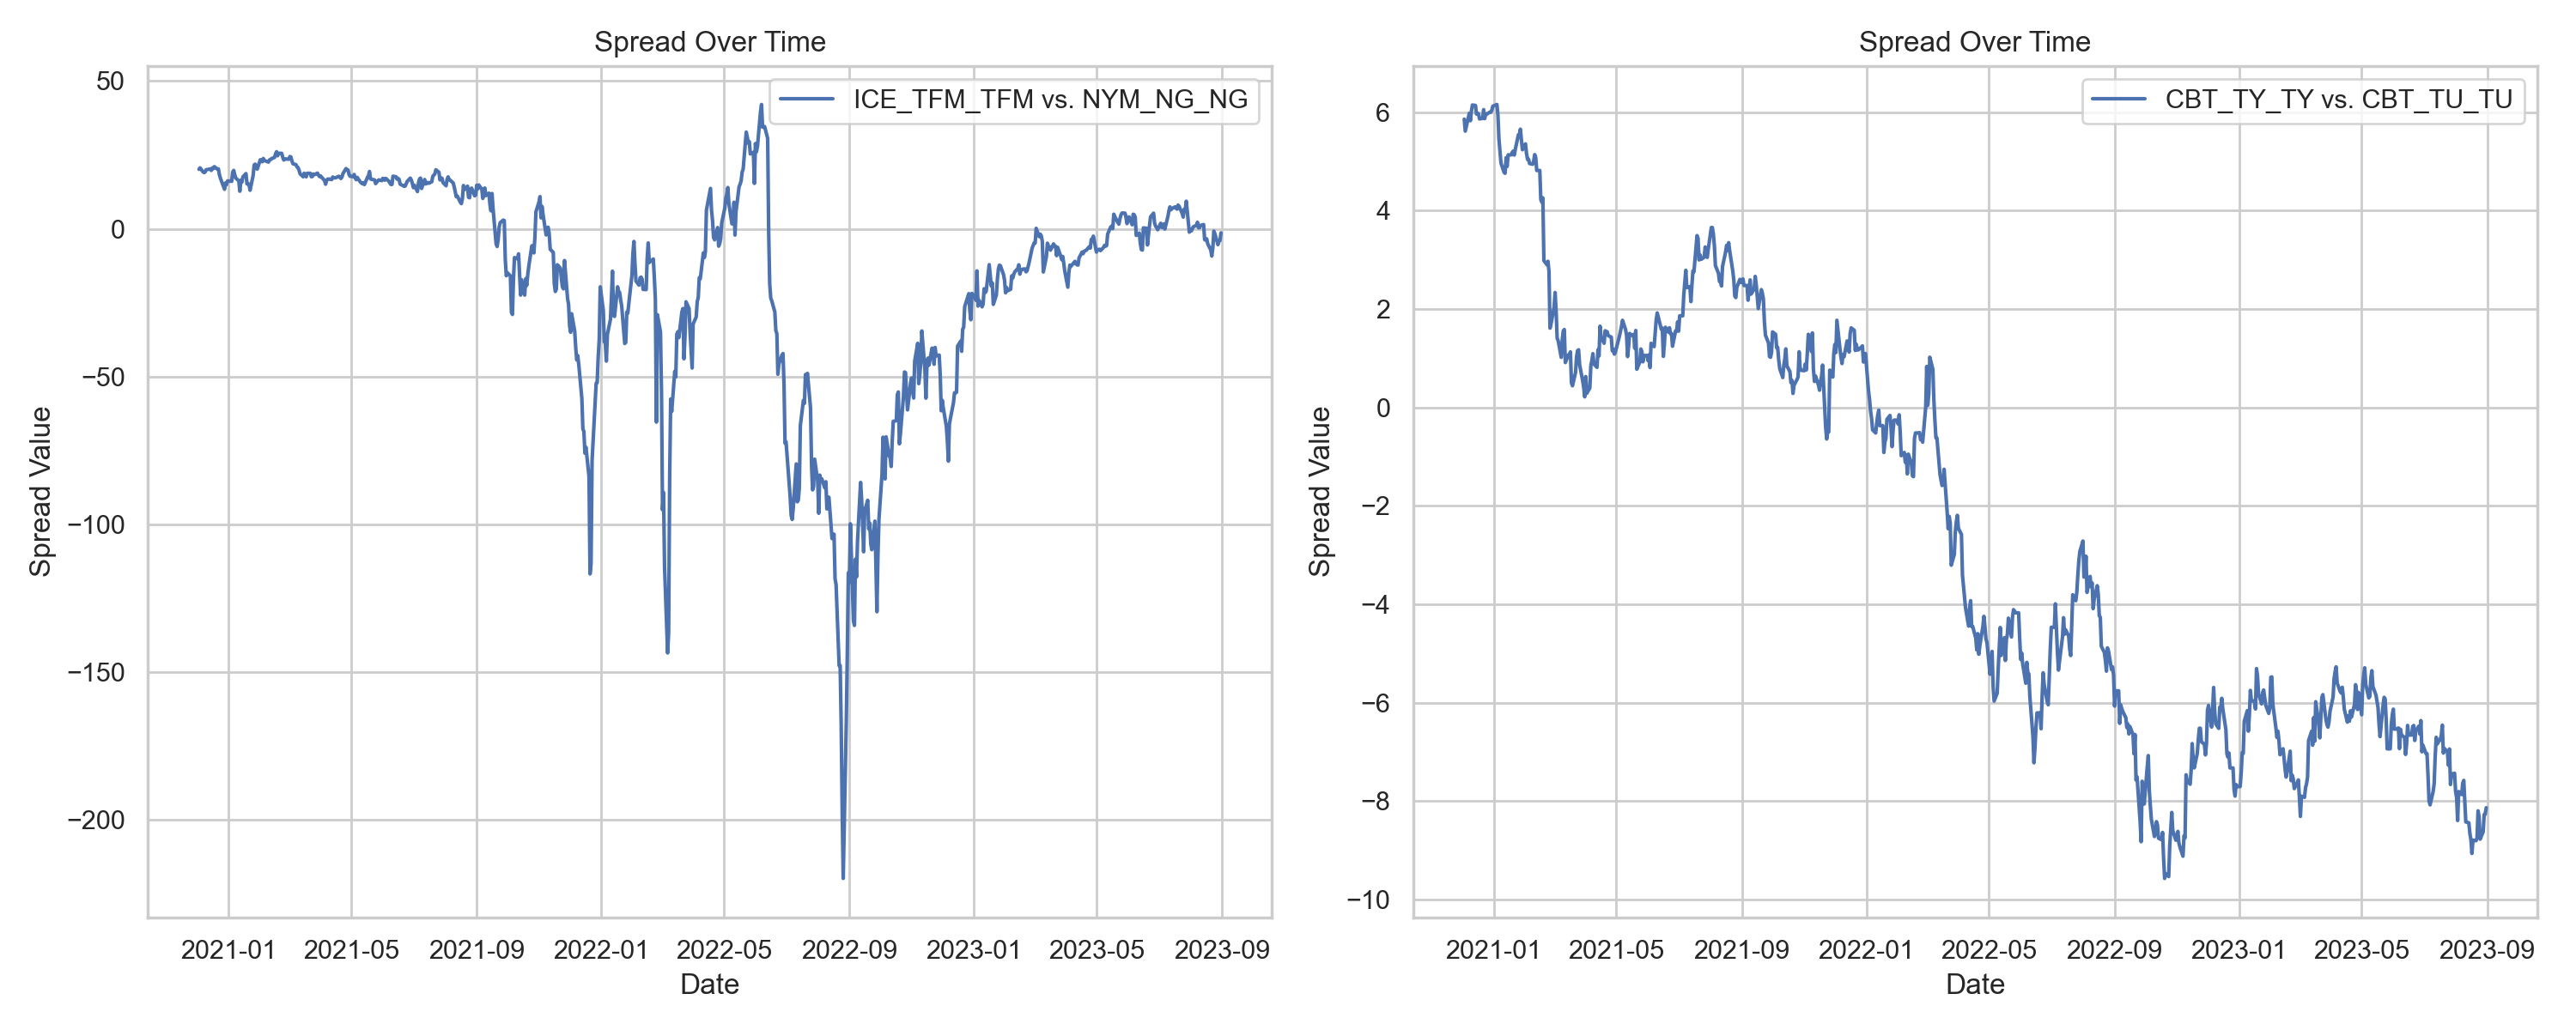

In [332]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(spread_X_W.index, spread_X_W['spread'], label=f'{W} vs. {X}')
plt.title('Spread Over Time')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(spread_Z_Y.index, spread_Z_Y['spread'], label=f'{Z} vs. {Y}')
plt.title('Spread Over Time')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.legend()

plt.tight_layout()
plt.show()

We also want to check if there are any outliers in our data. The plots seem to show that there are no outliers in our data, even if the plot for the spread between X and W shows a few large drops in 2022.

Therefore, we are ready to start our analysis.

### 3. Individual Spread Analysis

In this first analysis part, we will focus on identifying the dynamics of each spread individually. We will start by computing some basic statistics for our spreads. We will then compute the statistics for the difference of our spreads with their rolling-average. Finally, we will compute different correlations, the cross-correlation of the spreads, but also their autocorrelation and the seasonality of the spreads.

#### 3.1. Statistical Analysis

Let's start our analysis by computing the basic statistics for our spreads and by plotting them with those statistics to see if we can observe any patterns.

In [333]:
def statistical_summary(data):
    summary_stats = data.mean().to_frame('Mean')
    summary_stats['Standard Deviation'] = data.std()
    summary_stats['Variance'] = data.var()

    summary_stats['Skewness'] = data.skew()
    summary_stats['Excess Kurtosis'] = data.kurtosis()
    summary_stats['Empirical VaR (0.05)'] = data.quantile(.05, axis=0)
    summary_stats['Empirical CVaR (0.05)'] = data[data <= data.quantile(.05, axis=0)].mean()
    summary_stats['Min'] = data.min()
    summary_stats['Max'] = data.max()

    summary_stats['5% Quantile'] = data.quantile(.05, axis=0)
    summary_stats['25% Quantile'] = data.quantile(.25, axis=0)
    summary_stats['50% Quantile'] = data.quantile(.5, axis=0)
    summary_stats['75% Quantile'] = data.quantile(.75, axis=0)
    summary_stats['95% Quantile'] = data.quantile(.95, axis=0)

    return summary_stats

In [334]:
stats_X_W = statistical_summary(spread_X_W)
stats_X_W

Mean  Standard Deviation     Variance  Skewness  Excess Kurtosis  \
spread -16.554151           39.591478  1567.485137  -1.46119         2.278729   

        Empirical VaR (0.05)  Empirical CVaR (0.05)         Min        Max  \
spread            -98.326738            -124.479412 -219.842655  42.048807   

        5% Quantile  25% Quantile  50% Quantile  75% Quantile  95% Quantile  
spread   -98.326738    -34.057828     -5.682208     15.081948     22.875266

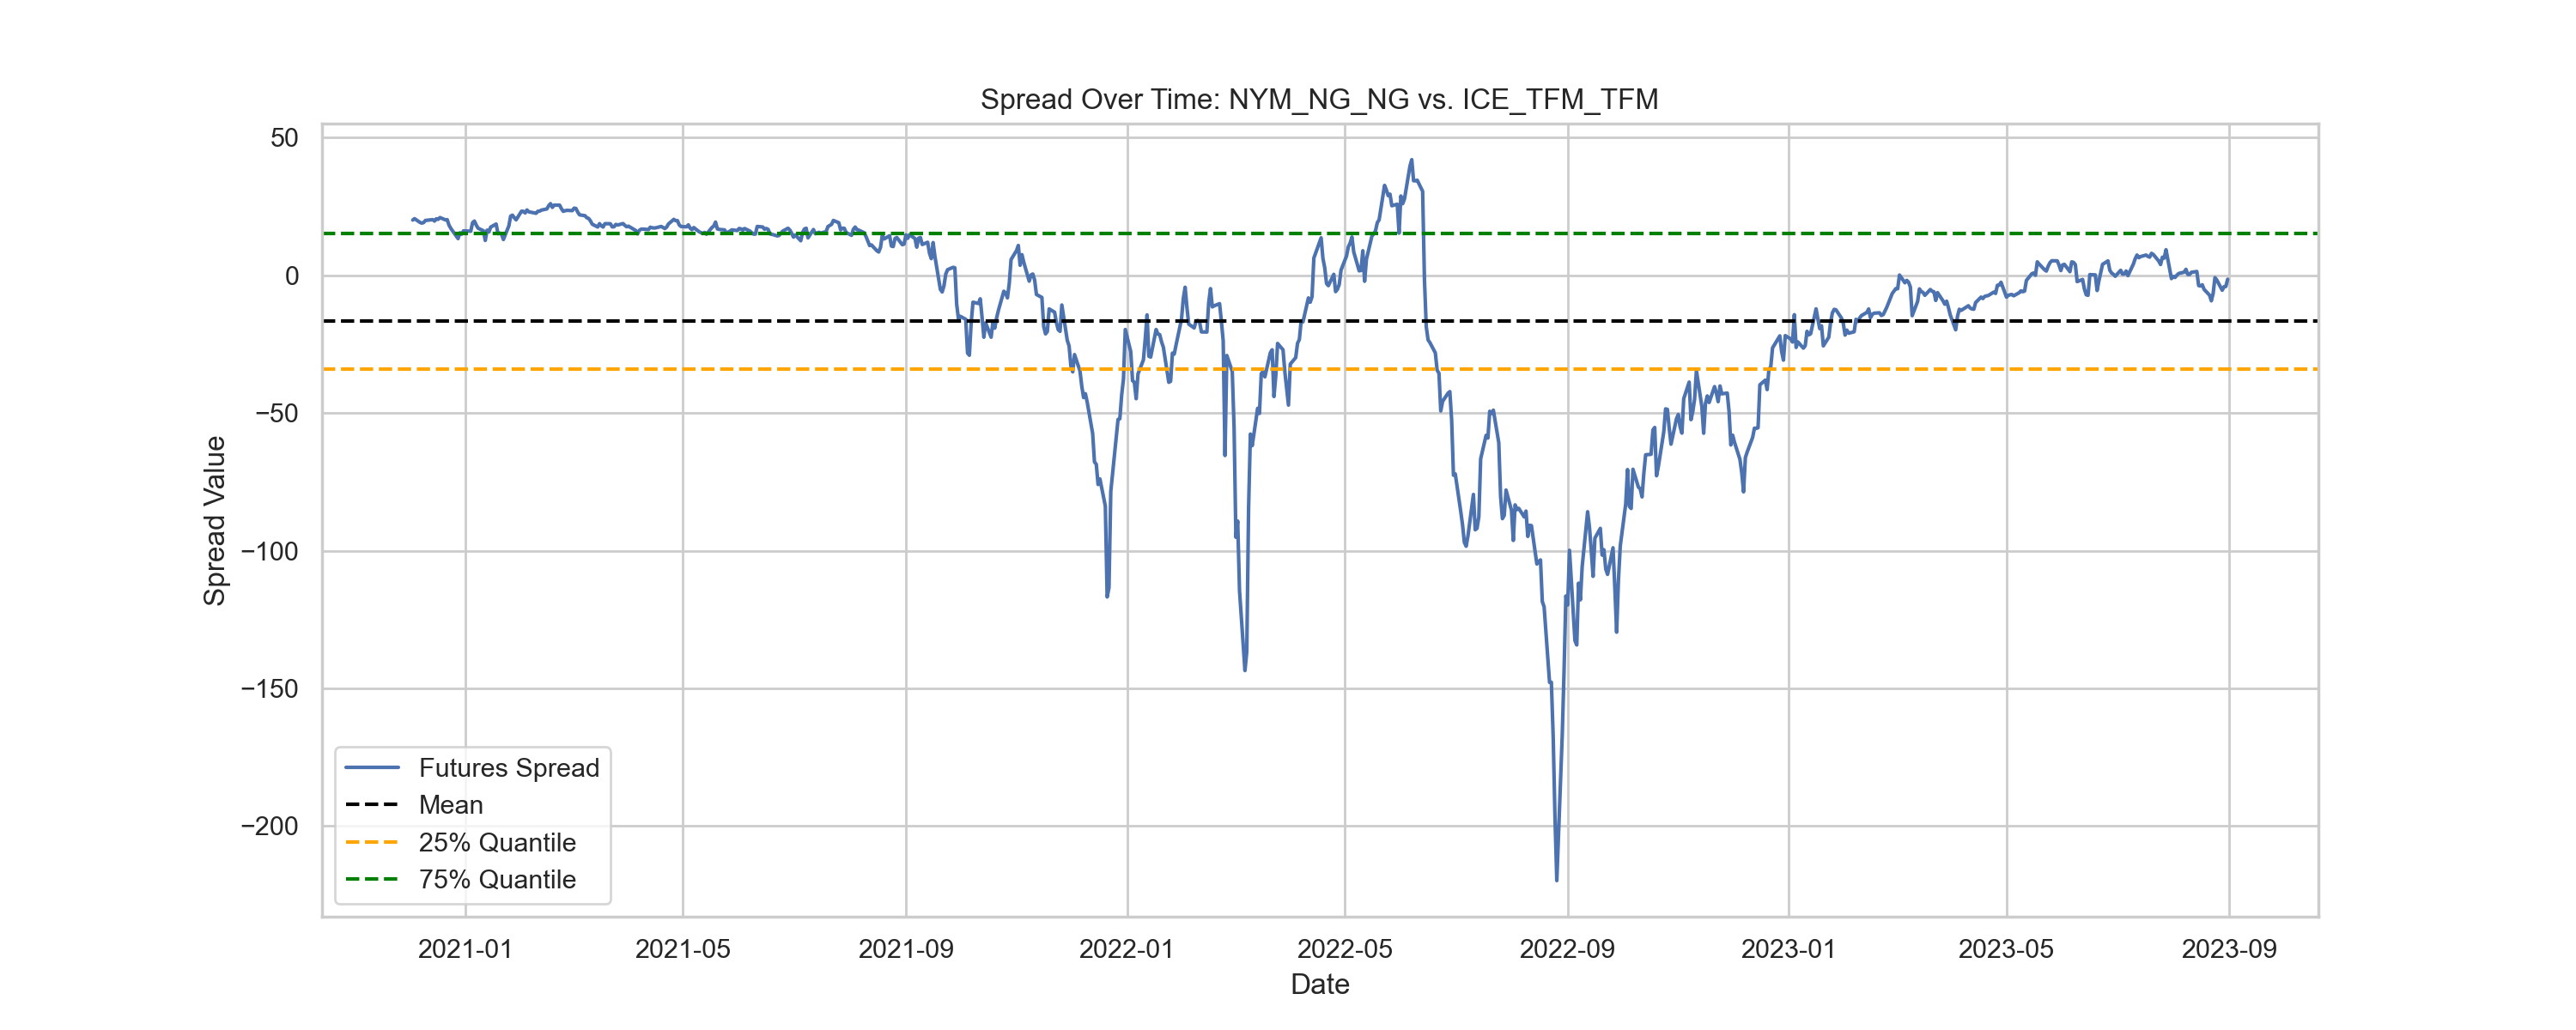

In [335]:
plt.figure(figsize=(15, 6))
plt.plot(spread_X_W.index, spread_X_W['spread'], label='Futures Spread')
plt.axhline(y=stats_X_W['Mean'].values[0], color="black", linestyle="dashed", label='Mean')
plt.axhline(y=stats_X_W['25% Quantile'].values[0], color="orange", linestyle="dashed", label='25% Quantile')
plt.axhline(y=stats_X_W['75% Quantile'].values[0], color="green", linestyle="dashed", label='75% Quantile')
plt.title(f'Spread Over Time: {X} vs. {W}')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.legend()
plt.show()

Based on the graph we computed and the statistics we calculated, we can see that the spread between X and W has a negative mean indicating that on average, the price of the shorter-term future is typically lower than that of the longer-term future. It is also quite volatile with a large standard deviation.

The spread is negatively skewed, with a skewness of -1.46, which indicates a tail on the left side of the distribution. The kurtosis on the over hand is positive around of 2.28, which indicates a 'heavier' tail compared to a normal distribution, i.e., more prone to outliers.

The graph represents the spread of the Dutch TTF Natural Gas Futures (ICE TFM) vs. Henry Hub Natural Gas Futures (NYM NG). It shows that the spread experienced several large drops in 2022 before recovering in 2023. It is now around 0, and it seems to be quite stable. It suggests that the ratio does not trend in any direction in the long run, but rather oscillates around a mean value. We will be able to look more closely at this in the trend and seasonal analysis.

If we look at the quantiles, we can see that the spread is living between -200 and +50. The 25% quantile is around -35, while the 75% quantile is around +15. The 5% quantile is around -100, while the 95% quantile is around +20. This again indicates that the spread is quite volatile and that it can experience large drops before recovering. Since the quantiles are quite tight, this supports the idea that the spread has no trend in the long run but rather tends to stay around the historical mean.

Those first observations let us think that the spread is mean-reverting and that futures prices on Natural Gas are not trending in the long run, but rather oscillate, sometimes quite strongly, around a mean value. Those oscillations can be understood through the seasonality of Natural Gas and by considering geopolitical events that can affect the price in different countries. We can think about the recent events in Europe with the Russian invasion of Ukraine and the Nord Stream 2 pipeline incident.

In [336]:
stats_Z_Y = statistical_summary(spread_Z_Y)
stats_Z_Y

Mean  Standard Deviation   Variance  Skewness  Excess Kurtosis  \
spread -2.42355            4.384776  19.226258  0.223897        -1.311627   

        Empirical VaR (0.05)  Empirical CVaR (0.05)       Min       Max  \
spread             -8.327734              -8.773433 -9.571008  6.154375   

        5% Quantile  25% Quantile  50% Quantile  75% Quantile  95% Quantile  
spread    -8.327734      -6.43134     -3.623211       1.24618      5.132639

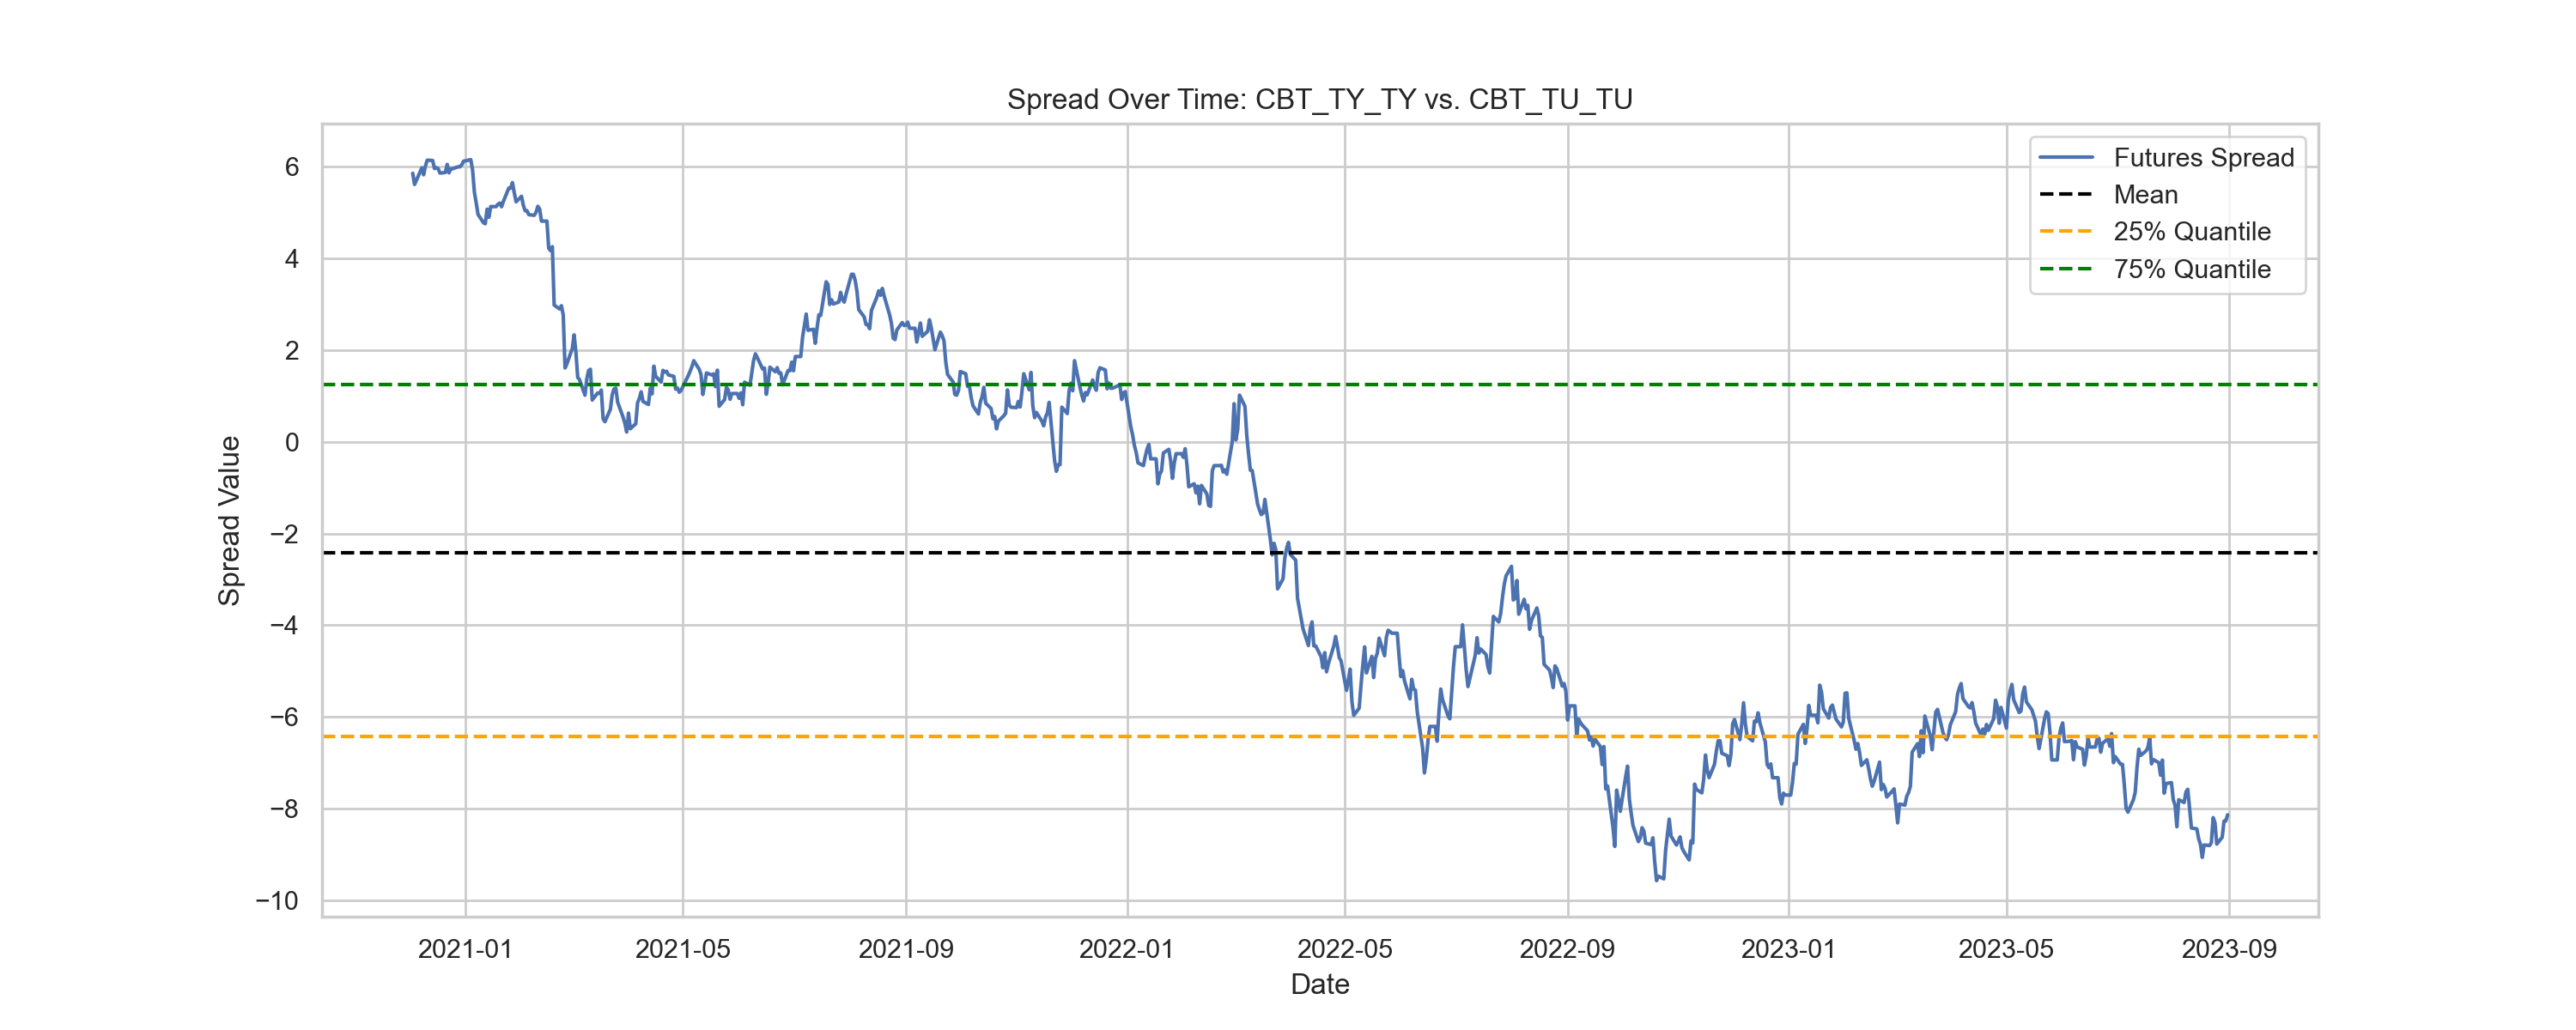

In [337]:
plt.figure(figsize=(15, 6))
plt.plot(spread_Z_Y.index, spread_Z_Y['spread'], label='Futures Spread')
plt.axhline(y=stats_Z_Y['Mean'].values[0], color="black", linestyle="dashed", label='Mean')
plt.axhline(y=stats_Z_Y['25% Quantile'].values[0], color="orange", linestyle="dashed", label='25% Quantile')
plt.axhline(y=stats_Z_Y['75% Quantile'].values[0], color="green", linestyle="dashed", label='75% Quantile')
plt.title(f'Spread Over Time: {Z} vs. {Y}')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.legend()
plt.show()

Compared to what we observed for the spread between X and W, the spread between Z and Y shows an inversion from +5 in 2021 to -5 in the middle of 2022. That is what explain the negative mean of the spread which has been living between -5 and -10 since then. This spread is also much less volatile and does not appear to be skewed.

The graph represents the spread of the 10-Year U.S. Treasury Note (CBT TY) vs. the 2-Year U.S. Treasury Note (CBT TU). It shows that the spread experienced a downward trend since 2021 until 2023. It is now around -7, and it seems to have stabilized in 2023. This behavior indicates that the price of the shorter-term future is higher than that of the longer-term future. Contrary to the previous spread, this one does not oscillate around the mean value but rather trends downward. We will be able to look more closely at this in the trend and seasonal analysis.

If we now look at the quantile, we can see that the 25% quantile and the 75% quantile are quite far from the mean value and from each other. The spread does not lie between them for a long period of time but instead tends to move from one to the other. Since the quantiles are quite wide, this supports the idea that the spread has a trend in the long run and that it does not oscillate around the historical mean.

From those observations, we can infer the presence of a trend in the spread between Z and Y. This trend is downward and has been observed since 2021. It can be explained by economic factors such as the inflation rate or the series of interest rate hikes by central banks globally on that period of time. We could also have a look at the yield curve to see if it matches the inversion moment we observed in the spread.

#### 3.2. Rolling Average Analysis

We will now compute the statistics for the difference of our spreads with their rolling-average. To do so, we will use different window size of 5, 20, 50 and 100 days.

By extending the window size, we will be able to reduce the effects of daily price variation and therefore to better identify the long-term trends in the spreads. Those larger windows will also allow us to better identify the seasonality of the spreads by unveiling patters.

Conversely, shorter windows are more sensitive to immediate market shifts, reacting quickly to daily events. This sensitivity can be advantageous for capturing the market's immediate responses.

In contrast, the insights gained from examining the data through larger windows contribute to our understanding of the spread's dynamics.

In [338]:
window_sizes = [5, 20, 50, 100]


def plot_rolling_statistics(spread_data, window_sizes):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(len(window_sizes), 2, figsize=(15, 4 * len(window_sizes)))

    rows = []
    difference_data = pd.DataFrame()

    for i, N in enumerate(window_sizes):
        rolling_avg = spread_data['spread'].rolling(window=N).mean()
        difference = spread_data['spread'] - rolling_avg

        axes[i][0].plot(spread_data.index, spread_data['spread'], label='Spread', color='blue')
        axes[i][0].plot(spread_data.index, rolling_avg, label=f'{N}-Day Rolling Average', color='orange')
        axes[i][0].set_title(f'Spread and {N}-Day Rolling Average')
        axes[i][0].set_xlabel('Date')
        axes[i][0].set_ylabel('Spread')
        axes[i][0].legend()

        axes[i][1].plot(spread_data.index, difference, label=f'Difference with {N}-Day Avg', color='green')
        axes[i][1].set_title(f'Difference with {N}-Day Rolling Average')
        axes[i][1].set_xlabel('Date')
        axes[i][1].set_ylabel('Difference')
        axes[i][1].legend()

        row = {
            'Window_size': N,
            'Mean': np.mean(difference),
            'Std_dev': np.std(difference),
            'Min': difference.min(),
            'Max': difference.max()
        }

        quantiles = difference.quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
        for quantile, value in quantiles.items():
            row[f'{int(quantile * 100)}% Quantile'] = value

        rows.append(row)

        difference_data[f'Difference_{N}'] = difference

    plt.tight_layout()
    plt.show()

    stats_df = pd.DataFrame(rows)
    return difference_data, stats_df.set_index('Window_size')

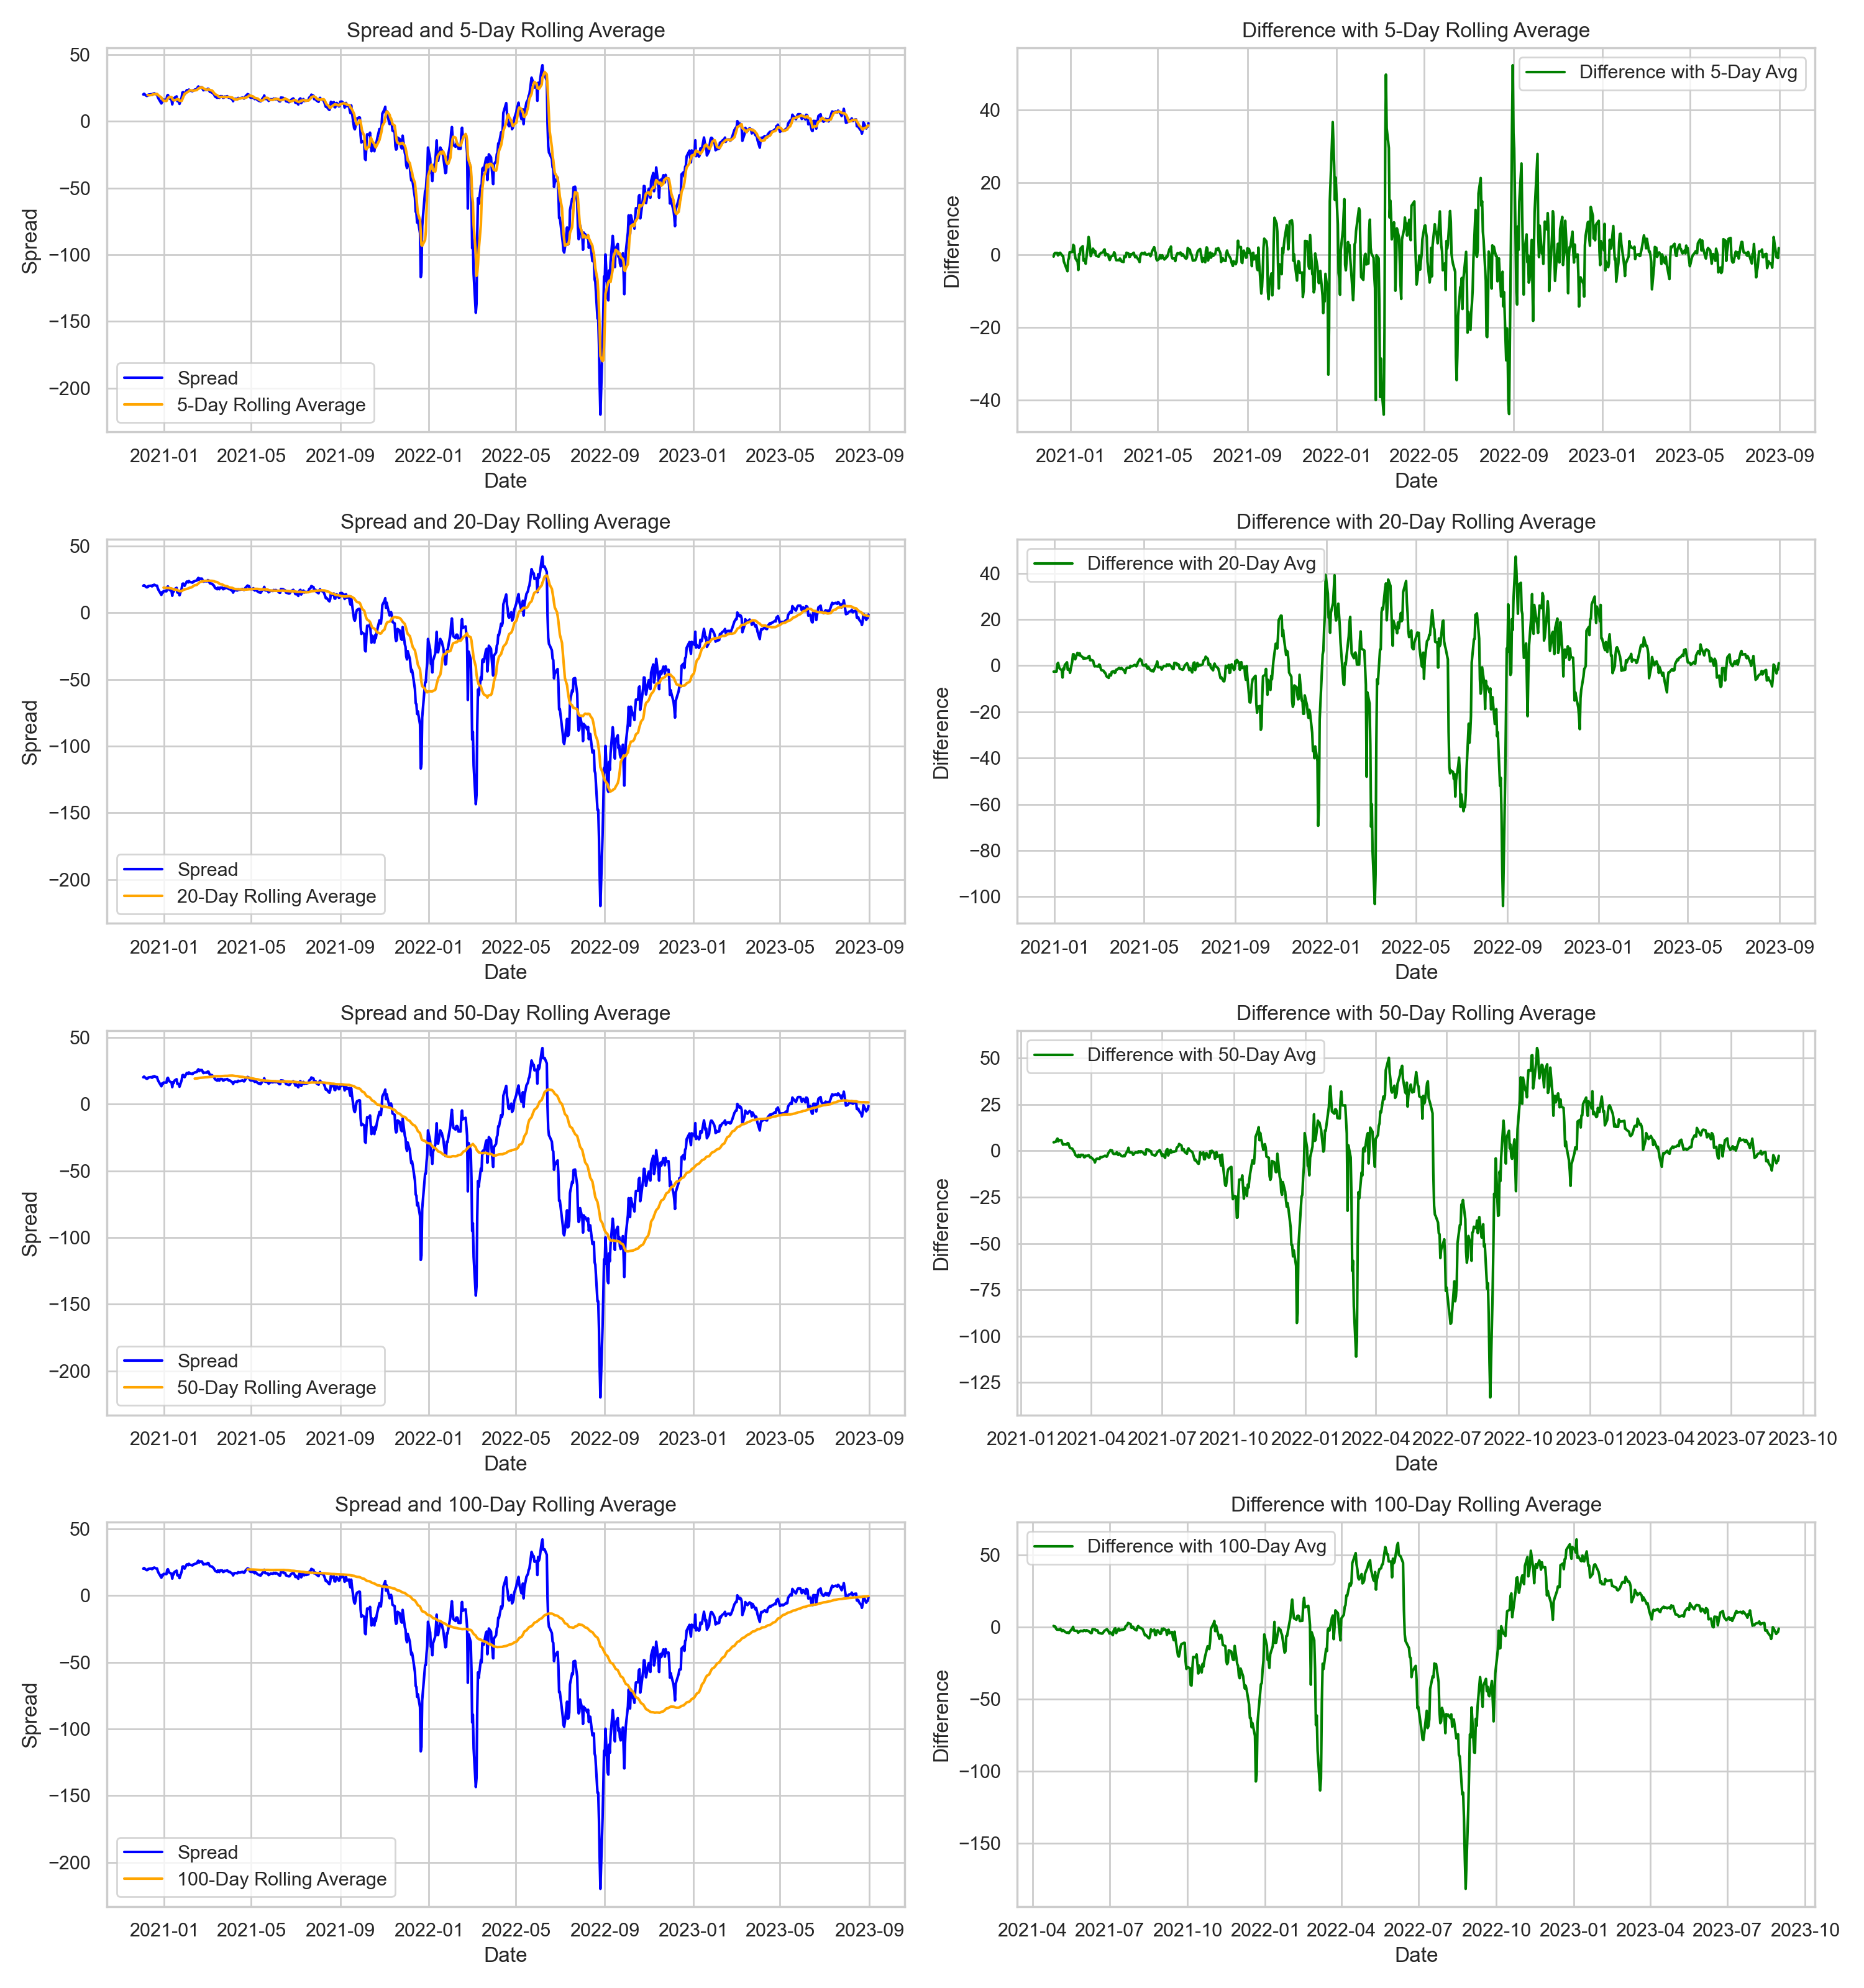

Mean    Std_dev         Min        Max  1% Quantile  \
Window_size                                                            
5           -0.064192   8.831949  -44.005015  52.342064   -32.826521   
20          -0.299831  18.180503 -104.074415  47.200089   -64.923554   
50          -0.734412  26.434367 -133.140709  55.531233   -90.508011   
100         -1.540463  34.925446 -181.887299  60.952476  -112.939833   

             5% Quantile  25% Quantile  50% Quantile  75% Quantile  \
Window_size                                                          
5             -12.100125     -2.054748      0.095411      2.188130   
20            -36.339939     -3.361108      0.660284      7.161838   
50            -53.427795     -5.036631      0.549796     12.658662   
100           -68.740872    -13.248788      0.199974     19.724583   

             90% Quantile  95% Quantile  99% Quantile  
Window_size                                            
5                7.784025     11.558994     29.520904  
20              19.510962     24.227812     35.637755  
50              29.338272     36.081926     46.591430  
100             41.120537     46.286792     53.839668

In [339]:
difference_data_X_W, stats_df_X_W = plot_rolling_statistics(spread_X_W, window_sizes)
stats_df_X_W

For all window sizes (5, 20, 50, 100 days), the means are negative, indicating a general trend where the spread is below the rolling average. Specifically, as the window size increases, the mean decreases (becomes more negative), suggesting a widening gap between the spread and its rolling average over longer periods. The left side graphs also show that as we look down (larger window sizes), the rolling average tends to depict a smoother trend, that we could identify as an absence of long-term trend. But on a shorter period of time, we can see that the rolling average tends to follow some seasonality patterns with a downward trend during winter months and an upward trend during summer months. Let's remind us that we are looking here at the spread between two natural gas futures, it is therefore not surprising to see such a seasonality pattern.

The standard deviation is very large and increases with the window size. This indicates greater variability in the difference between the spread, and its rolling average for larger window sizes. It implies that the spread fluctuates more compared to its rolling average over longer periods.

The minimum differences are increasingly negative with larger window sizes, while the maximum differences show a much slower increasing trend. This suggests that the spread experiences especially significant drops as the window size increases.

Lower quantiles (like 0.01, 0.05) show the values in the lower extreme. These values are increasingly negative with larger window sizes, suggesting more extreme drops in the spread compared to the rolling average. Higher quantiles (like 0.95, 0.99) show the higher extreme values. The trend here also increases with the window size, indicating more extreme peaks. The median (0.5 quantile) seems to stay approximately constant over the different window sizes.

Overall, these statistics indicate that the spread X_W tends to be below its rolling average, with more pronounced fluctuations and extreme negative values as the period of the rolling average increases. No trend is observed in the long run, but the spread tends to follow some seasonal patterns.

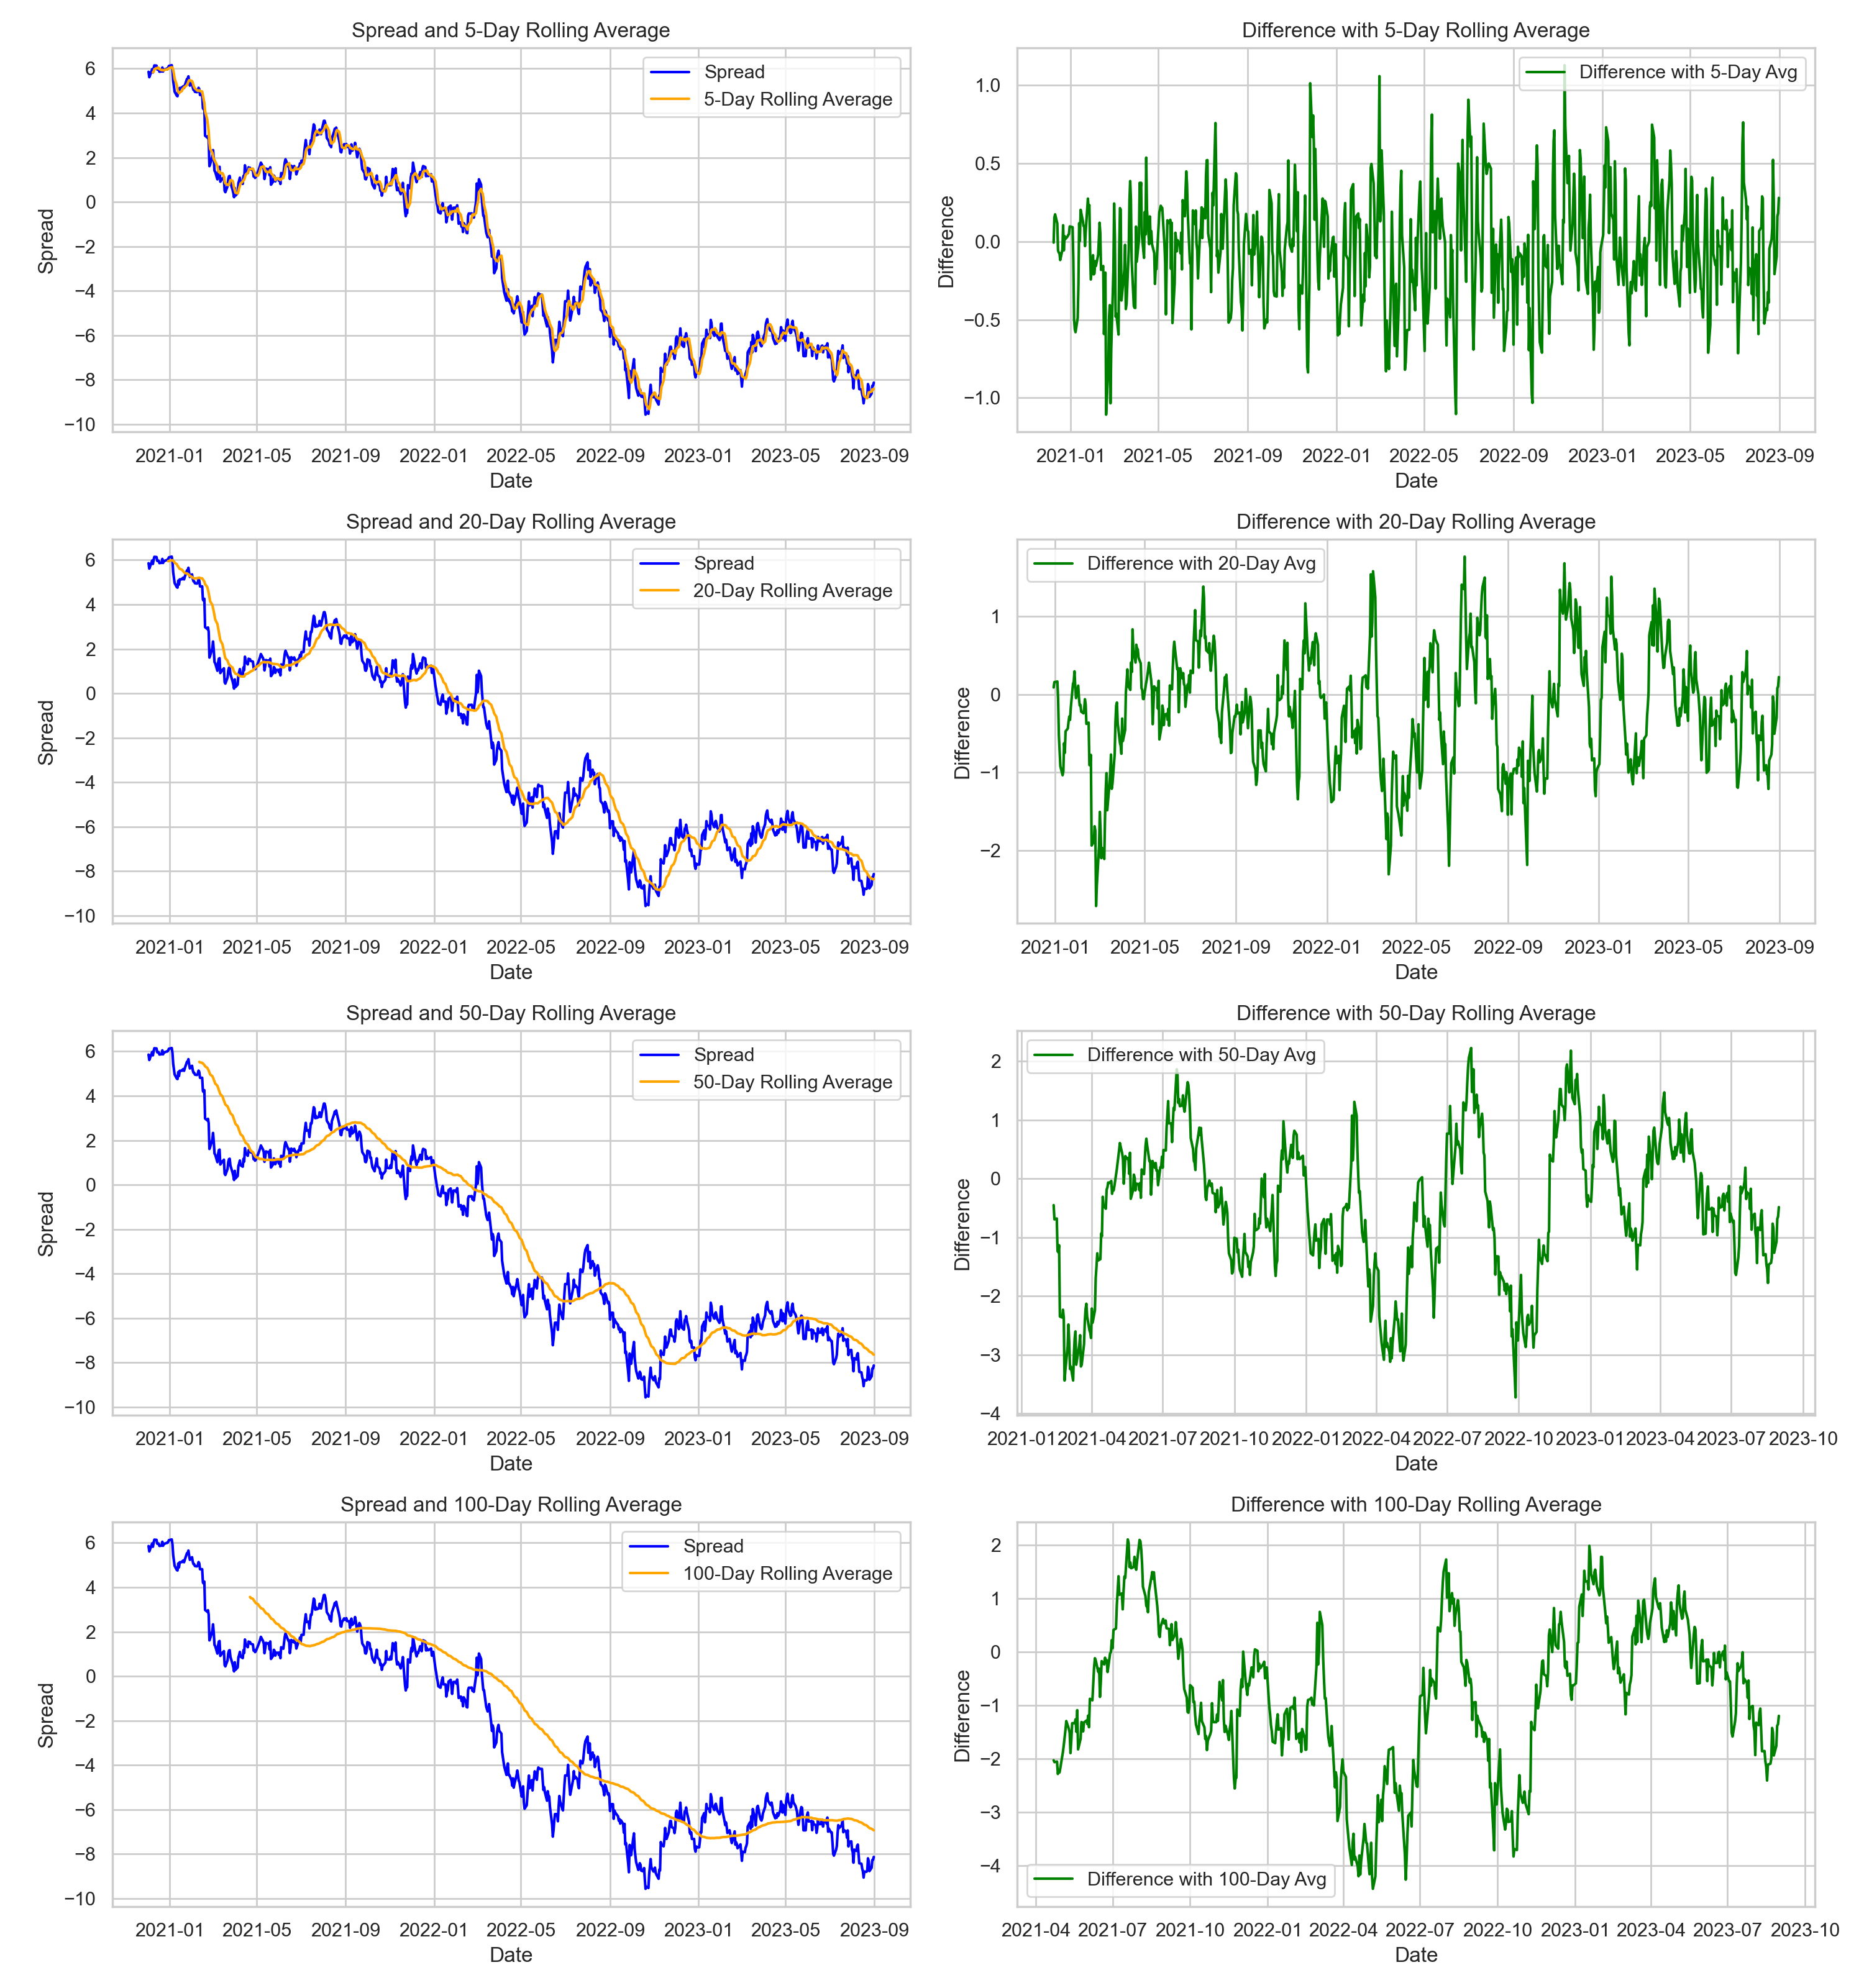

Mean   Std_dev       Min       Max  1% Quantile  5% Quantile  \
Window_size                                                                     
5           -0.039702  0.343405 -1.107156  1.129414    -0.828965    -0.590238   
20          -0.196989  0.750421 -2.711584  1.768318    -1.973541    -1.399896   
50          -0.491469  1.201864 -3.727570  2.227933    -3.199740    -2.708621   
100         -0.793590  1.401563 -4.430540  2.102129    -4.135368    -3.381939   

             25% Quantile  50% Quantile  75% Quantile  90% Quantile  \
Window_size                                                           
5               -0.270444     -0.042884      0.180407      0.397984   
20              -0.741033     -0.163381      0.297614      0.740620   
50              -1.277135     -0.423417      0.388905      1.016782   
100             -1.628278     -0.650360      0.277929      0.998868   

             95% Quantile  99% Quantile  
Window_size                              
5                0.521264      0.758652  
20               1.036362      1.409619  
50               1.308549      1.866404  
100              1.381677      1.818737

In [340]:
difference_data_Z_Y, stats_df_Z_Y = plot_rolling_statistics(spread_Z_Y, window_sizes)
stats_df_Z_Y

The means for Z and Y is close to 0 for all window sizes (5, 20, 50, 100 days) and the standard deviation increases a little bit with the window size but is very small compared to the differences between the spread and its rolling average for X and W. This indicates that the spread between Z and Y is generally close to its rolling average, with relatively small fluctuations over longer periods.

Contrary to the previous graphs, the rolling average here tends to follow a trend. It is downward for all window sizes, indicating that the spread is below its rolling average. We can clearly identify that trend by looking at the 100-day rolling average. This is consistent with what we observed in the previous section.

Lower quantiles (0.01, 0.05) show increasingly negative values with larger window sizes, indicating more large drops. Higher quantiles (0.95, 0.99) also increase with the window size, reflecting higher peak differences. The median (0.5 quantile) stays around 0 (negatively) as the window size increases, indicating that the typical difference is more below the rolling average for longer periods.

Overall, these statistics suggest that the downward trend we identified earlier is true in the long run over the observed period of time. The spread between Z and Y generally follows its rolling average, with little fluctuations.

#### 3.3. Risk Metrics Analysis

In order to better understand the dynamics of our spreads, we can have a look at some other risk metrics than the volatily that we already computed. We will have a look here at the Value-at-Risk (VaR) and the Expected Shortfall (ES) for our spreads.

In [341]:
daily_returns_X_W = spread_X_W['spread'].pct_change()
daily_returns_Z_Y = spread_Z_Y['spread'].pct_change()


def calculate_var(data, confidence_level=0.95):
    std_dev = data.std()
    var = norm.ppf(1 - confidence_level) * std_dev
    return var


def calculate_es(data, confidence_level=0.95):
    var = calculate_var(data, confidence_level)
    es = data[data < var].mean()
    return es


def risk_df(data, index_name, confidence_level=0.95):
    var = calculate_var(data, confidence_level)
    es = calculate_es(data, confidence_level)
    
    plt.figure(figsize=(10, 6))
    plt.plot(data, label='Daily Returns')
    plt.axhline(y=var, color='red', linestyle='--', label=f'VaR ({confidence_level*100}%)')
    plt.axhline(y=es, color='green', linestyle='--', label='ES')
    plt.title(f'Risk Metrics for {index_name}')
    plt.xlabel('Date')
    plt.ylabel('Daily Returns')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return pd.DataFrame({'VaR': [var], 'ES': [es]}, index=[index_name])

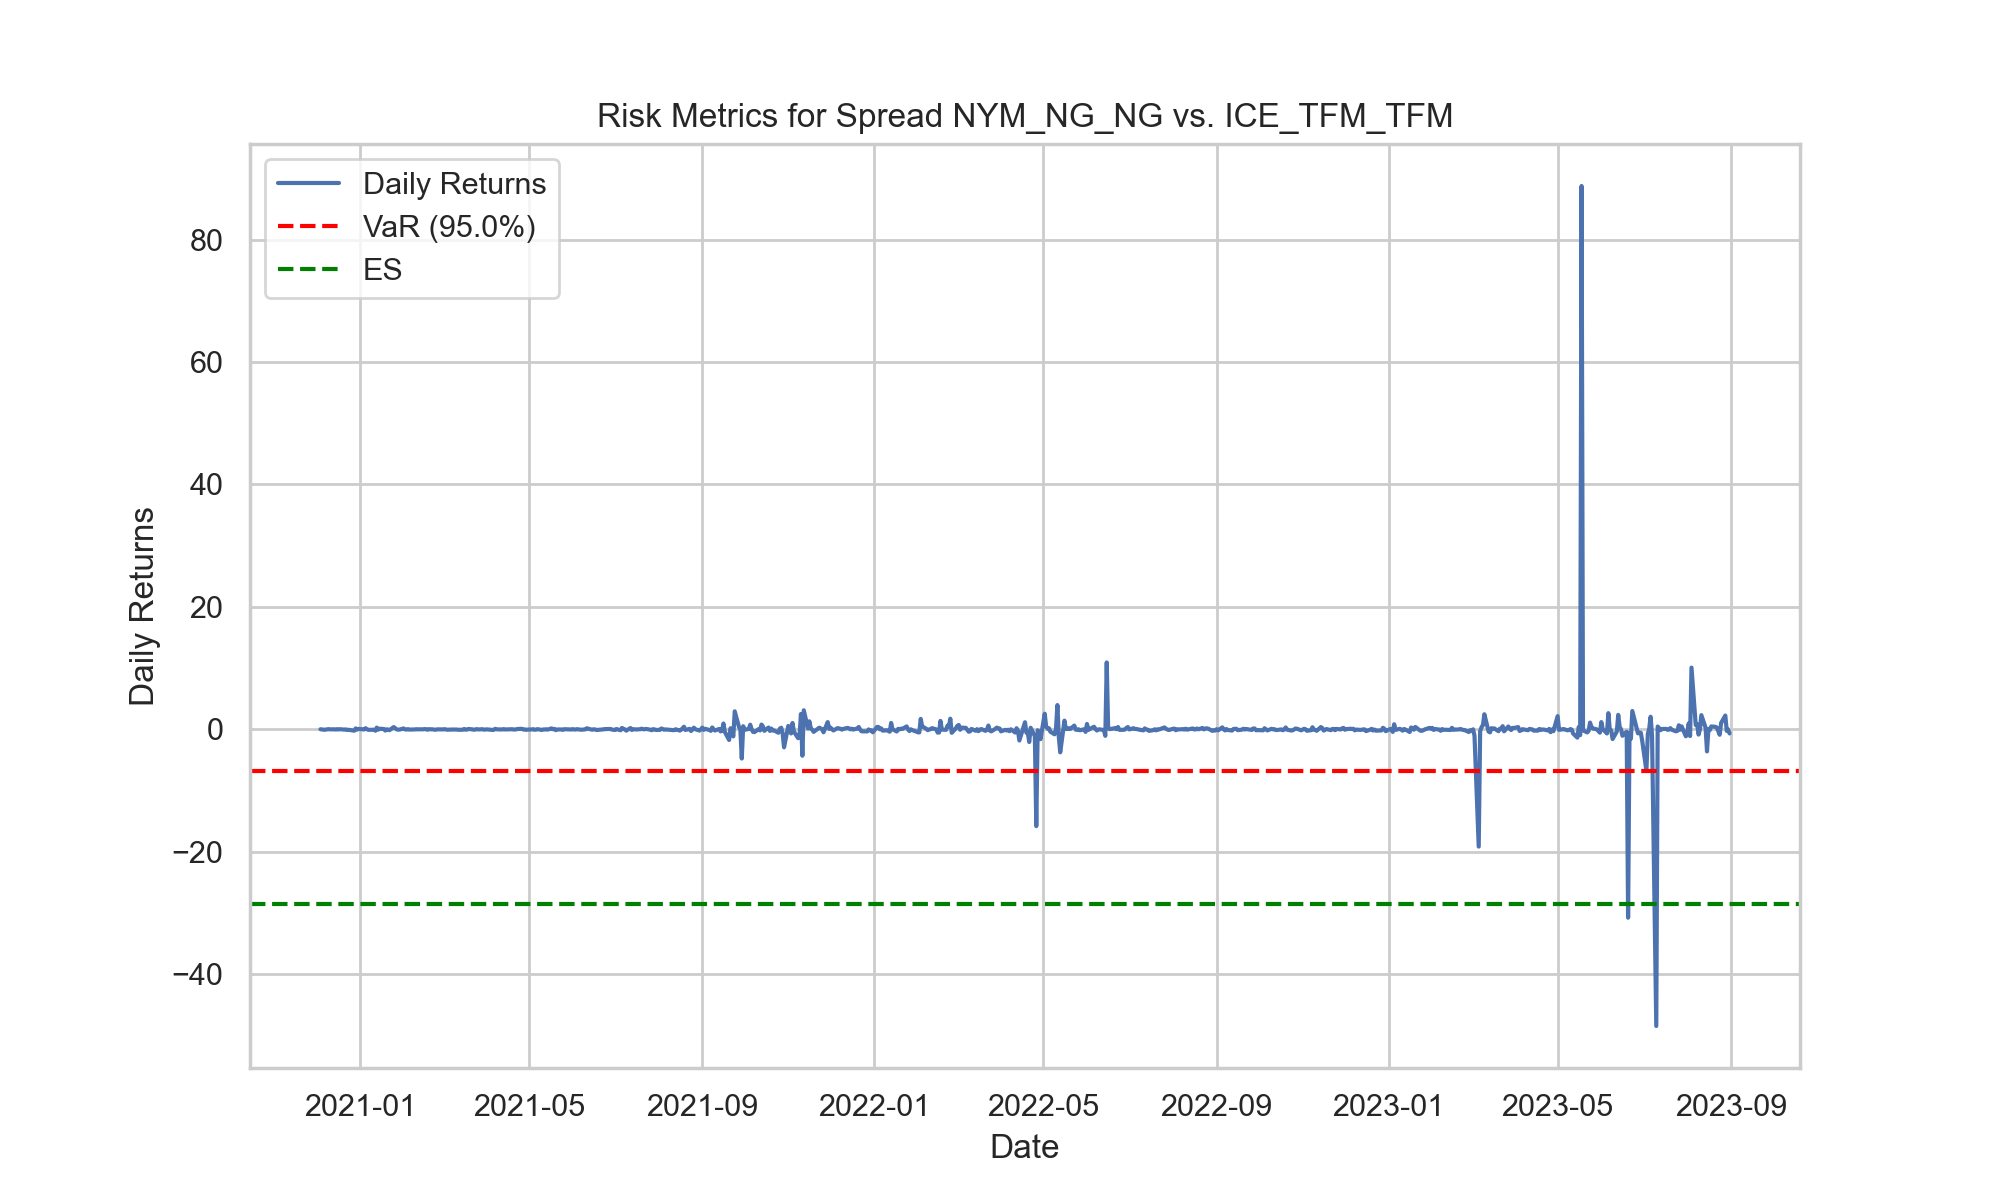

VaR         ES
Spread NYM_NG_NG vs. ICE_TFM_TFM -6.865667 -28.531483

In [342]:
risk_df(daily_returns_X_W, f'Spread {X} vs. {W}')

In [343]:
pd.DataFrame(daily_returns_X_W).idxmax()

spread   2023-05-18
dtype: datetime64[ns]

The plot displays the daily returns for the spread between X and W, as well as the VaR and ES for a confidence level of 95%. We can see some large movement back in the middle of 2023. Otherwise, the spread daily returns seems to be quite stable. As we can see, the VaR is around -7 while the ES is around -29, averaging out the losses beyond the VaR threshold to reflect the expected loss on days with the most severe declines.

If we look at the peak on 18 March 2023, we can see that it is related to the significant rise in natural gas production in the US, particularly from associated natural gas, which is a by-product of oil drilling. This increase was driven by higher crude oil prices, aging oil wells producing more natural gas, and more economical processing of associated natural gas due to penalties for venting and flaring methane. The Henry Hub spot price also rose during this period, reflecting these dynamics.

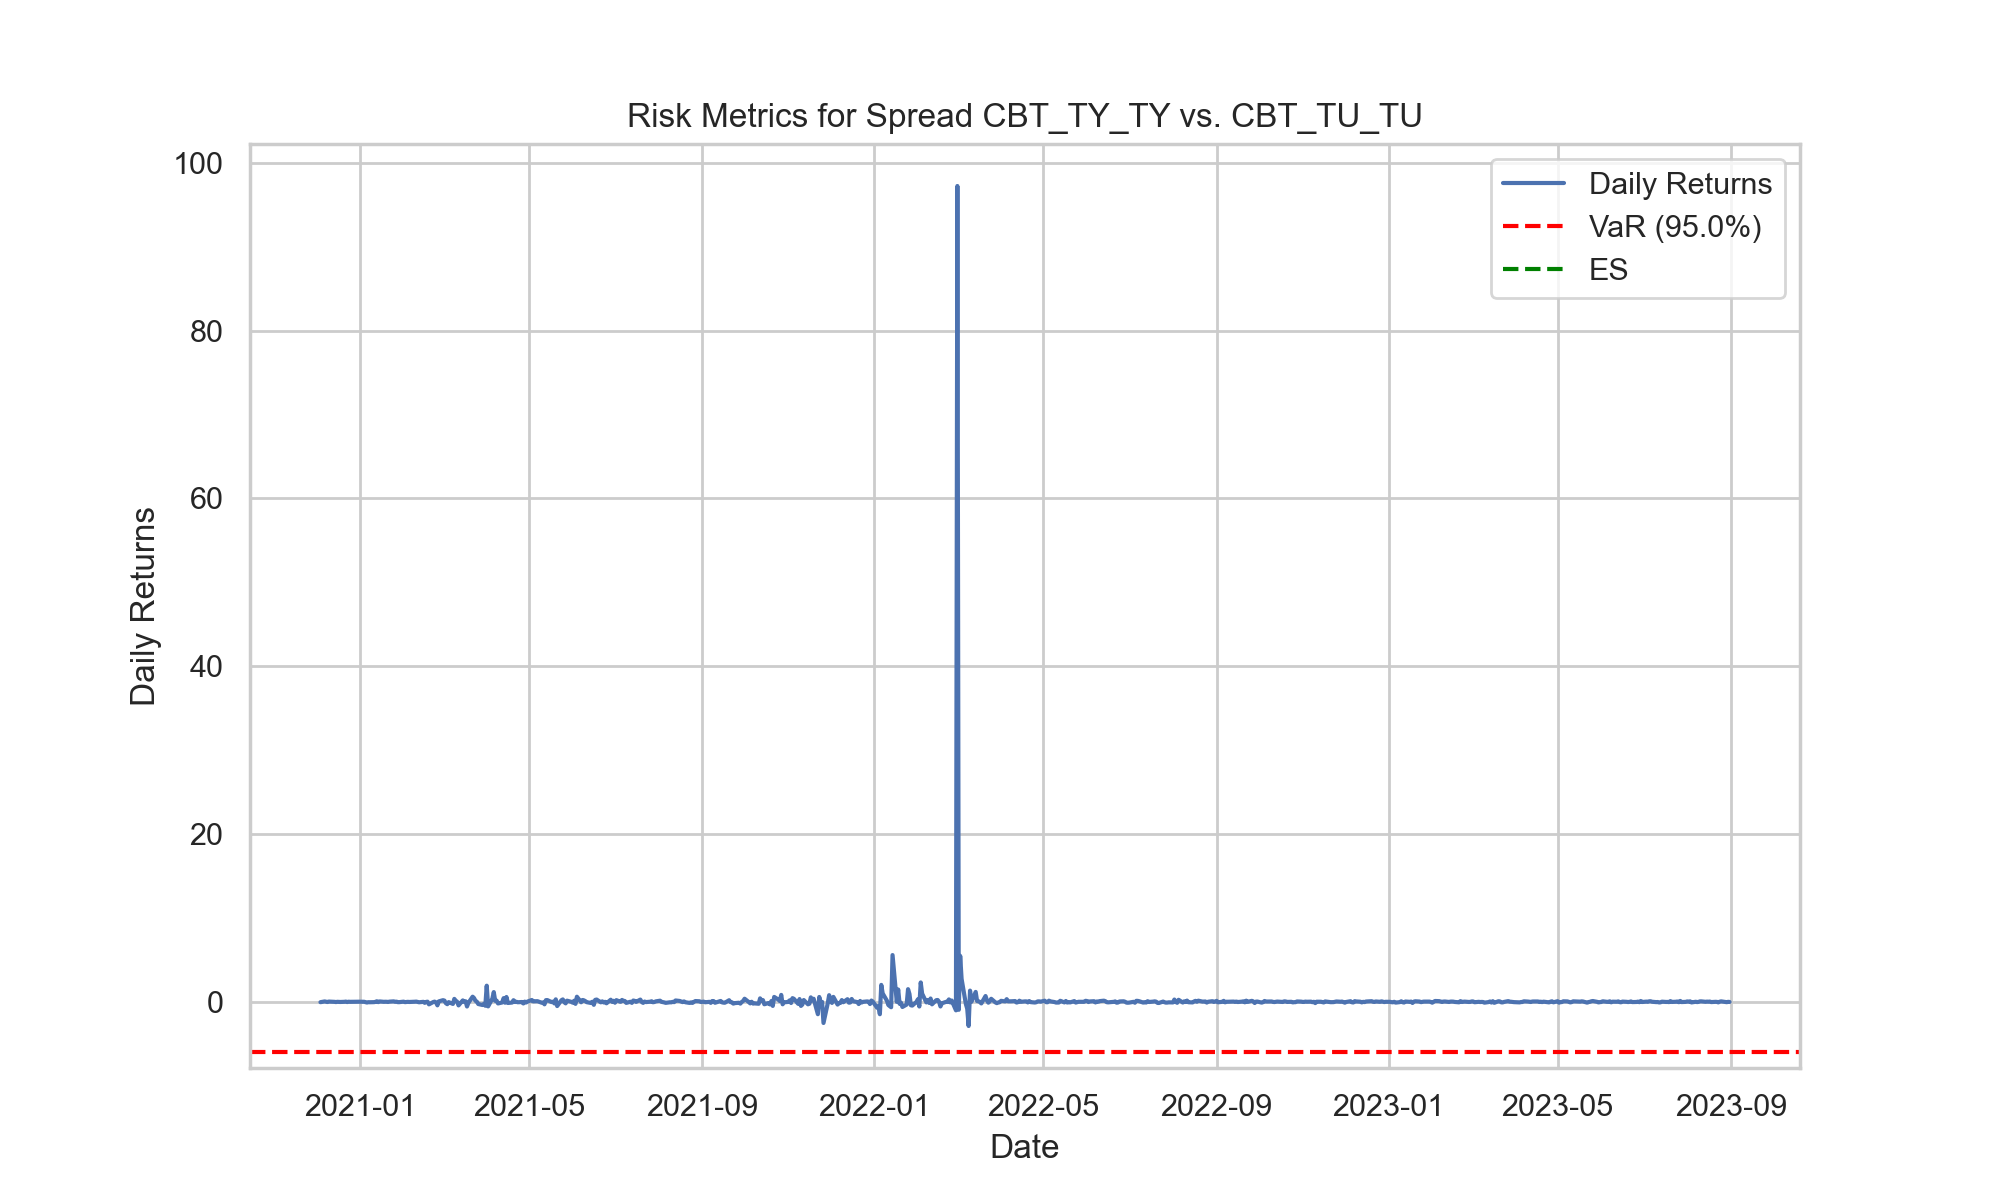

VaR  ES
Spread CBT_TY_TY vs. CBT_TU_TU -6.024767 NaN

In [344]:
risk_df(daily_returns_Z_Y, f'Spread {Z} vs. {Y}')

In [345]:
pd.DataFrame(daily_returns_Z_Y).idxmax()

spread   2022-03-01
dtype: datetime64[ns]

This plot displays the daily returns for the second spread between Z and Y. The VaR is around -6 while the ES is not available due to an insufficient number of instances where losses surpass the VaR. We can see that the returns are very small except for a short period of time at the beginning of 2022 where we can see some volatility, with a large peak on 1 March 2022. This date is to relate with the Fed's increasingly aggressive approach to combat inflation led to a sell-off in U.S. Treasuries. This was reflected in the rise of yields on U.S. benchmark 10-year Treasury notes, reaching their highest levels since May 2019. The Fed signaled its intention to tighten monetary policy further, with expectations of additional rate hikes.

#### 3.3. Autocorrelation Analysis

If we know try to look at some other aspects of our spreads, we can think about correlation and try to check if there exists some autocorrelation in our data. To do so, we will compute the autocorrelation for our spreads (working with the equivalent of daily returns) using different lags.

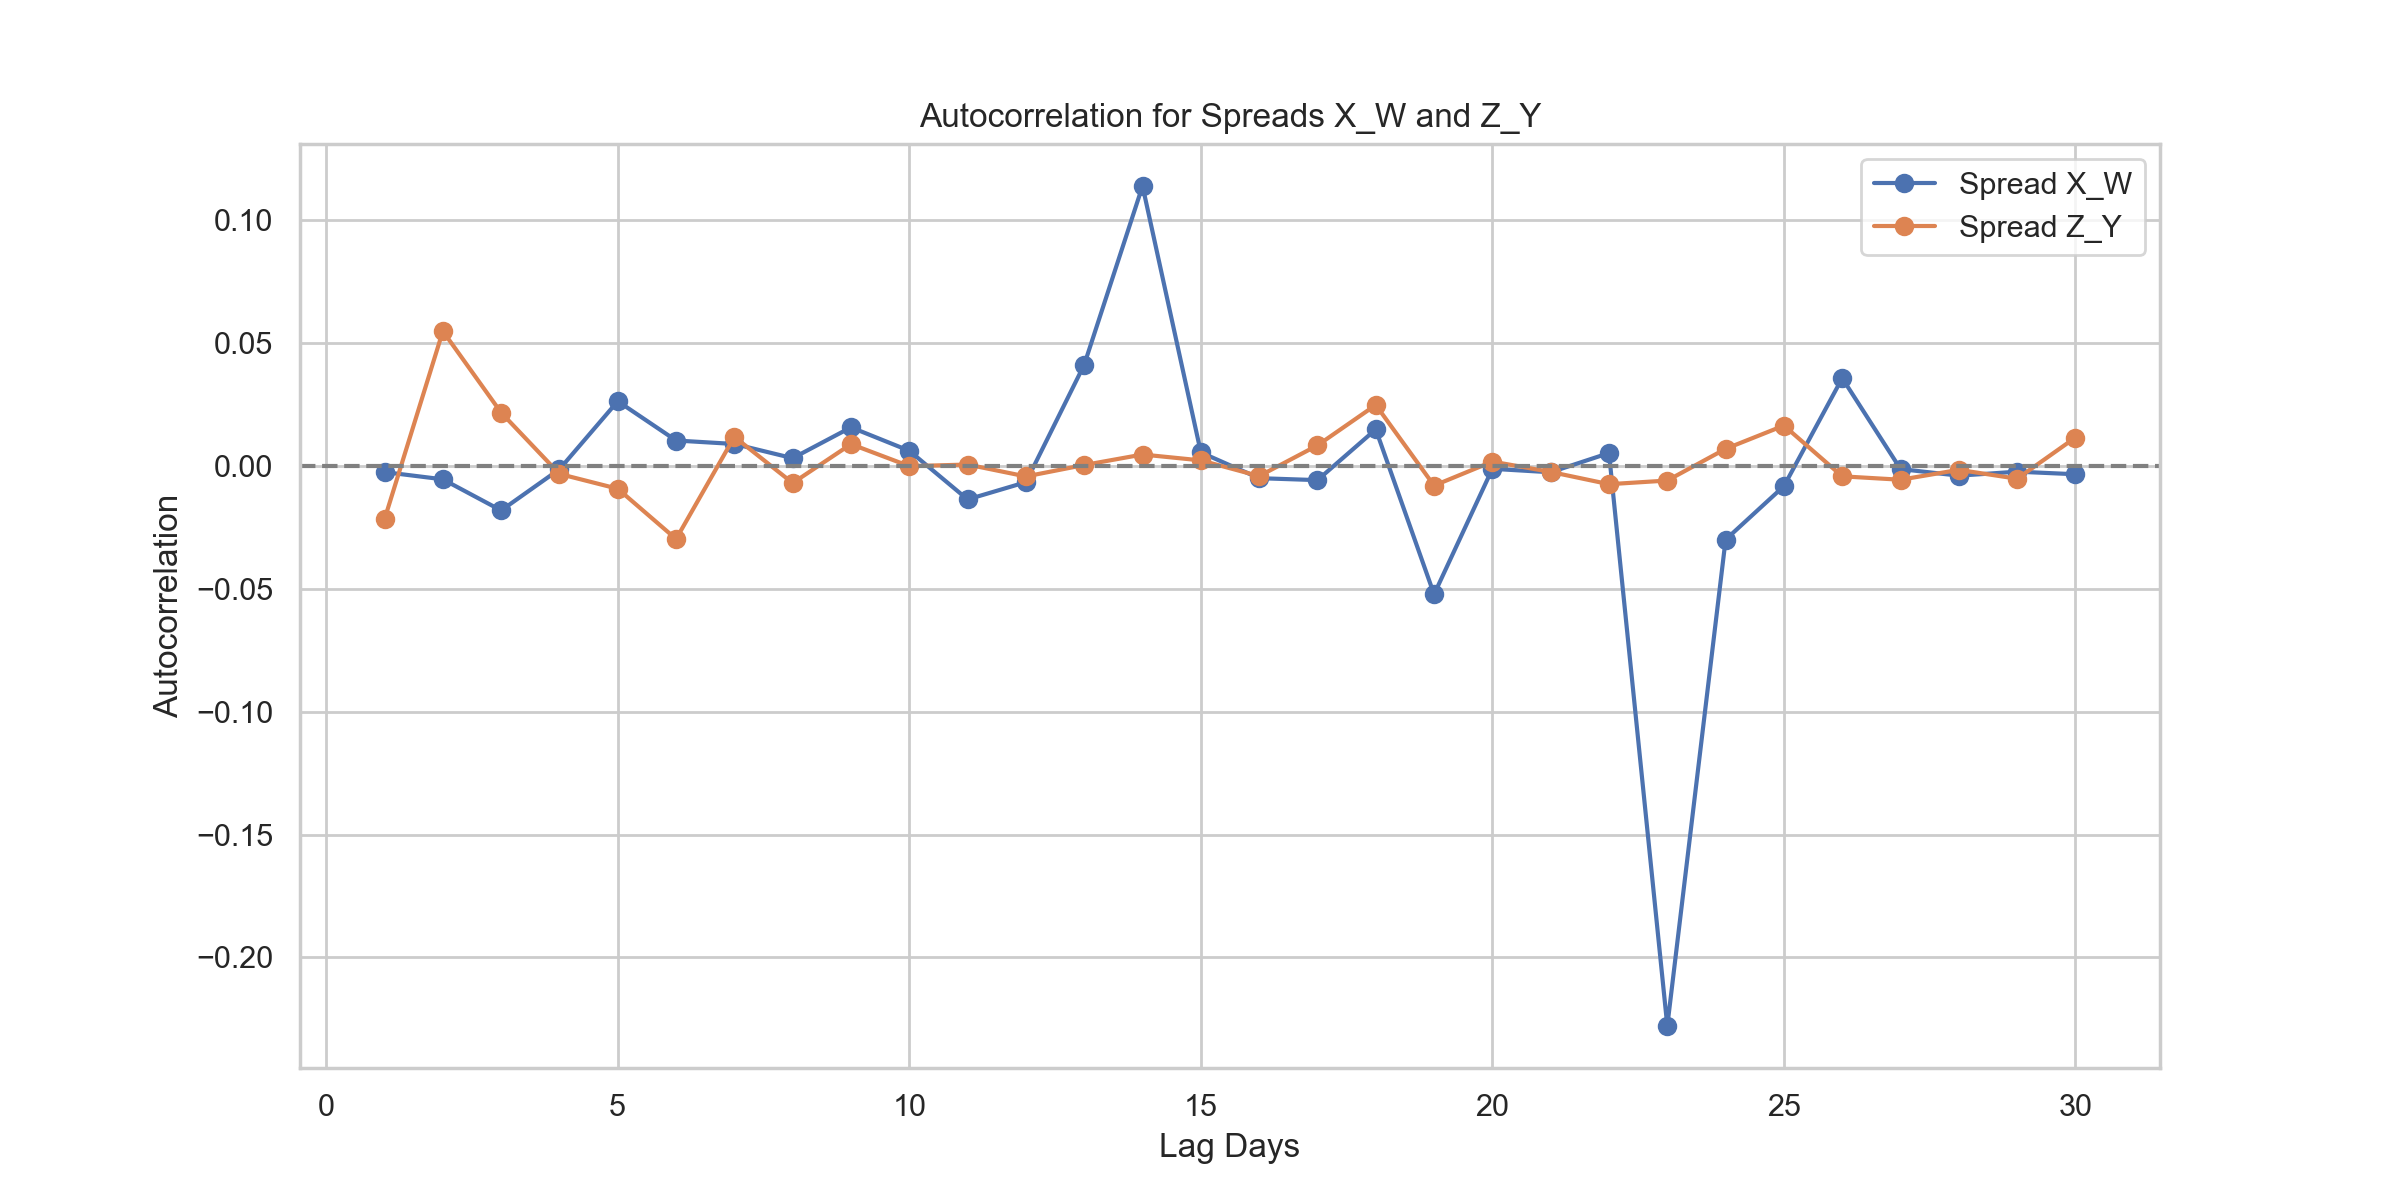

In [346]:
autocorr_X_W = [daily_returns_X_W.autocorr(lag=lag) for lag in range(1, 31)]
autocorr_Z_Y = [daily_returns_Z_Y.autocorr(lag=lag) for lag in range(1, 31)]

plt.figure(figsize=(12, 6))
plt.plot(range(1, 31), autocorr_X_W, marker='o', label='Spread X_W')
plt.plot(range(1, 31), autocorr_Z_Y, marker='o', label='Spread Z_Y')
plt.title('Autocorrelation for Spreads X_W and Z_Y')
plt.xlabel('Lag Days')
plt.ylabel('Autocorrelation')
plt.axhline(y=0, linestyle='--', color='gray')
plt.legend()
plt.show()

The plot displays the autocorrelation for each lag (up to 30 days) for the daily returns of spreads X_W and Z_Y.

On one hand, the autocorrelation values for spread X_W fluctuate around zero, but with some lags showing larger autocorrelation such as 14 days (0.11) and 23 days (0.24).

 On the other hand, the autocorrelation values for spread Z_Y also fluctuate around zero, with the magnitude of autocorrelation being low. Contrary to the previous spread, this one do not exhibit any significant autocorrelation, no matter the lag.

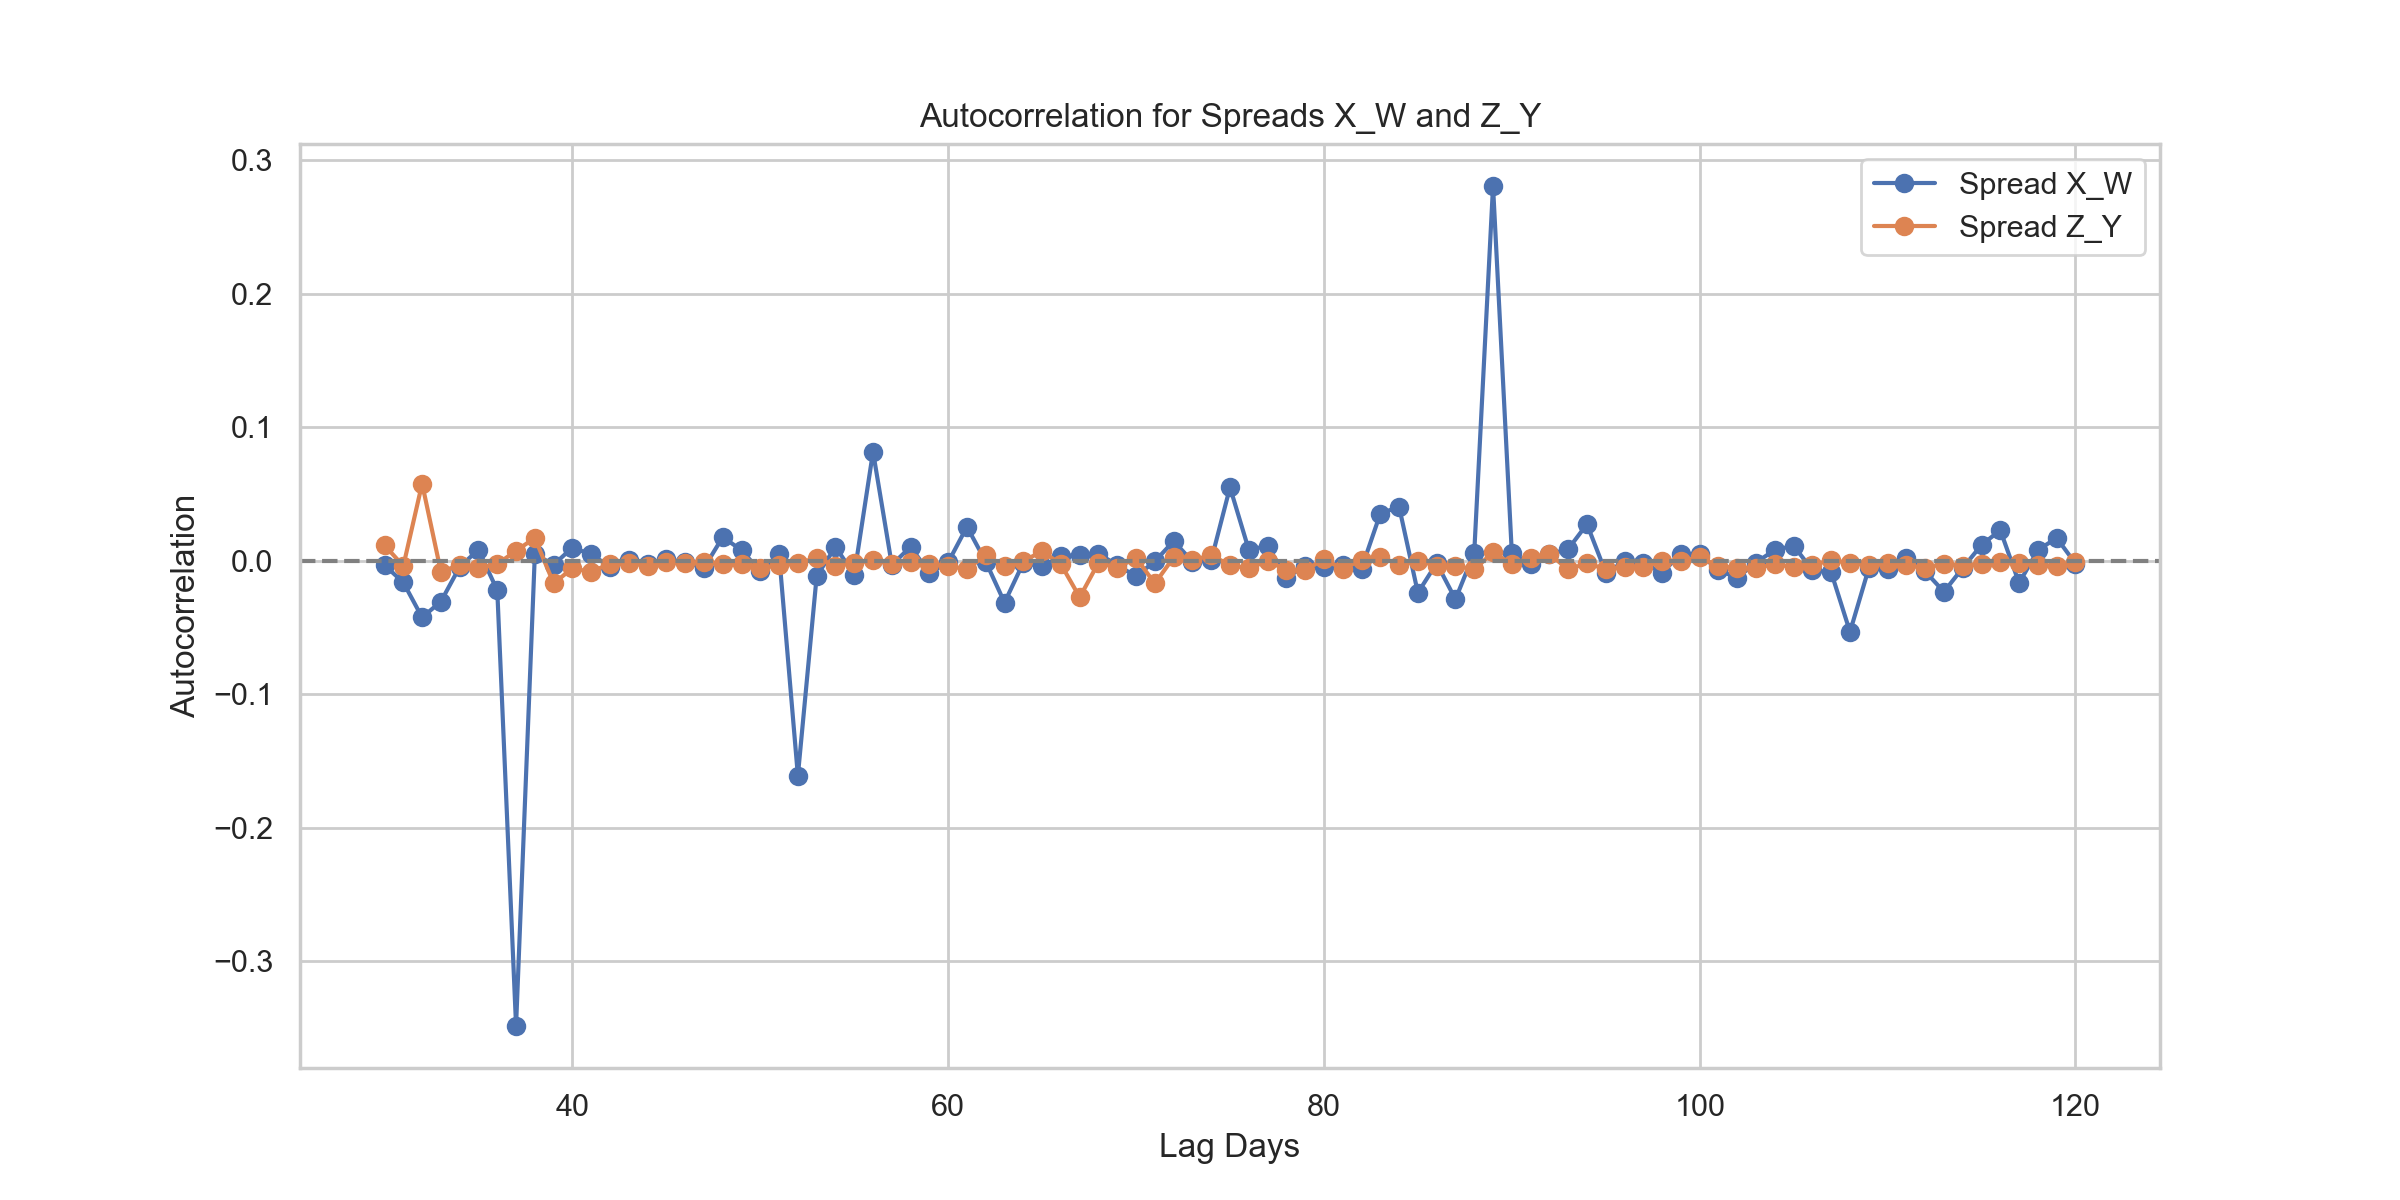

In [347]:
autocorr_X_W = [daily_returns_X_W.autocorr(lag=lag) for lag in range(30, 121)]
autocorr_Z_Y = [daily_returns_Z_Y.autocorr(lag=lag) for lag in range(30, 121)]

plt.figure(figsize=(12, 6))
plt.plot(range(30, 121), autocorr_X_W, marker='o', label='Spread X_W')
plt.plot(range(30, 121), autocorr_Z_Y, marker='o', label='Spread Z_Y')
plt.title('Autocorrelation for Spreads X_W and Z_Y')
plt.xlabel('Lag Days')
plt.ylabel('Autocorrelation')
plt.axhline(y=0, linestyle='--', color='gray')
plt.legend()
plt.show()

Looking now at more than a month in terms of lags, we can clearly see that the spread between Z and Y do not show any autocorrelation while the spread between X and W shows some even more interesting values. It achieves a score of around -0.35 for a lag of 37 days and almost +0.3 for a lag of 89 days.

The autocorrelation analysis suggests that the daily returns of the spread Z_Y do not exhibit strong or consistent dependencies on its past values for the given range of lags, while the spread X_W do. This information is crucial for financial modeling and forecasting, as it implies if simple autoregressive models might be effective in predicting future values based on past values for these spreads.

#### 3.4. Seasonality Analysis

In our previous analysis, we saw that a trend could be identified in the spread between Z and Y, so we are now going to check if this is really the case. We will also try to identify if there is some seasonality in our spreads, particularly on the spread between X and W since this is a spread on Natural Gas which is known to have some seasonality (summer and winter). To do so, we will use the `seasonal_decompose` function from the statsmodels library.

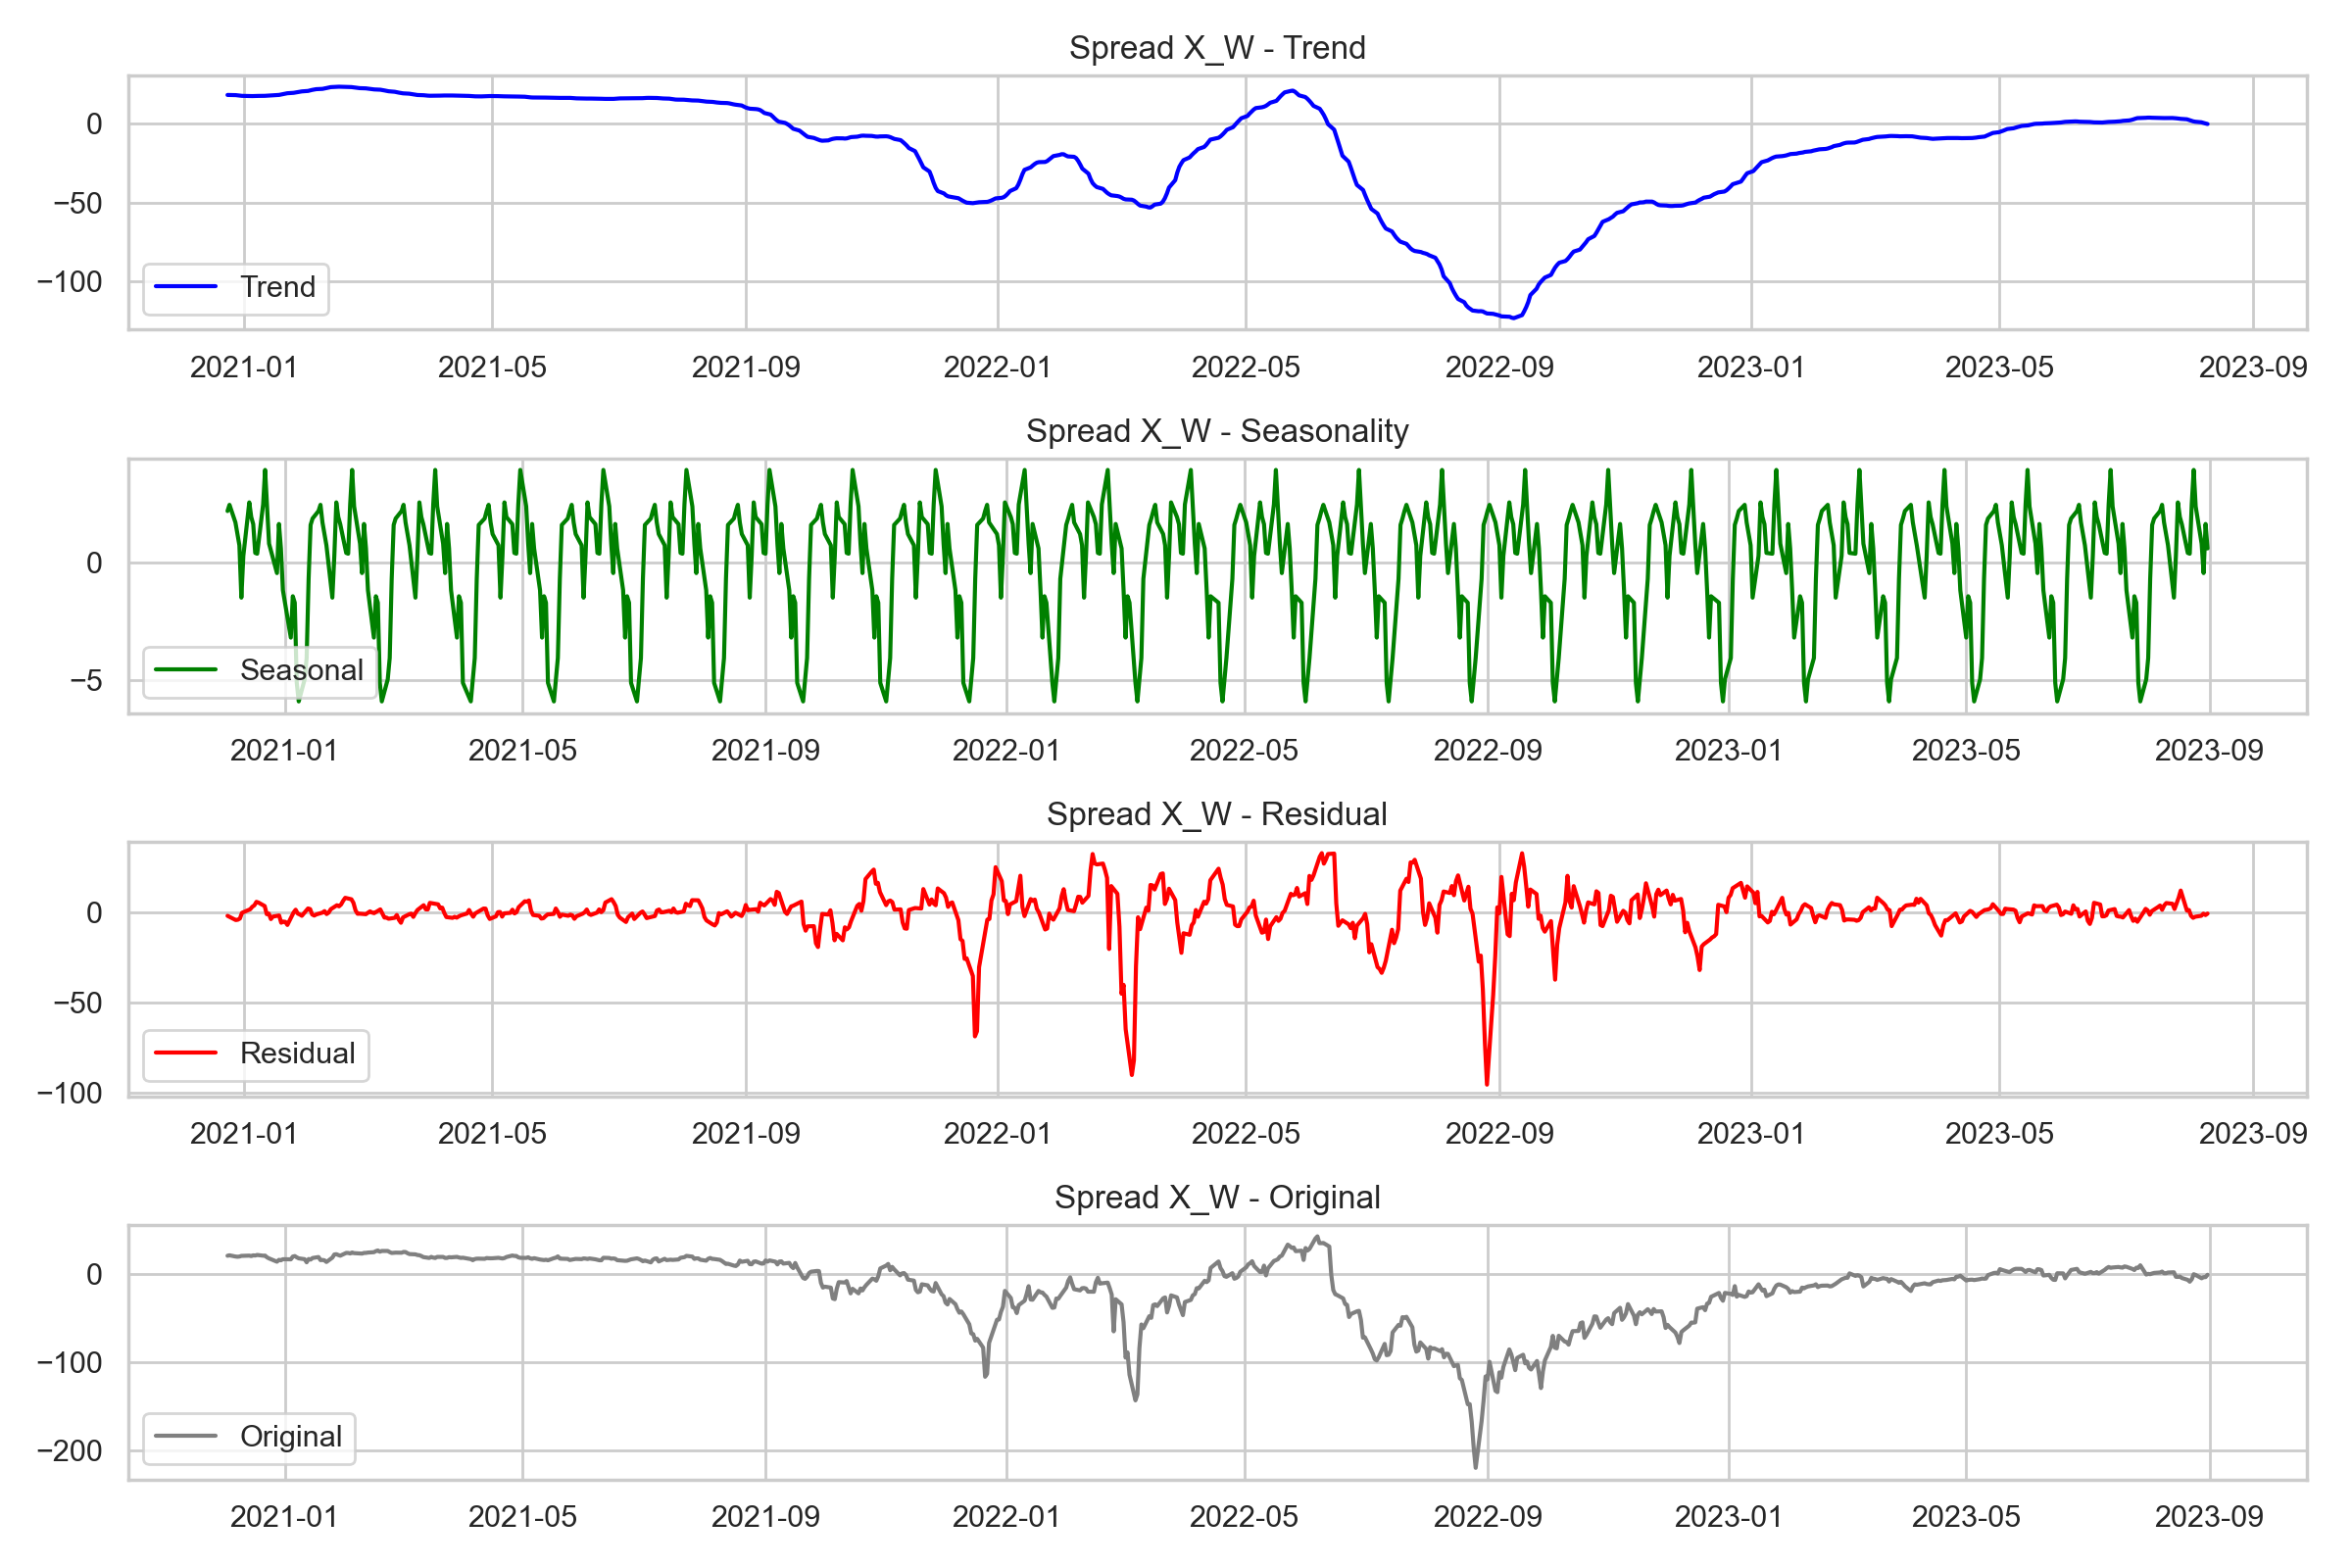

In [348]:
new_period = 30 # 1 month - 30 days

decompose_X_W = seasonal_decompose(spread_X_W['spread'], model='additive', period=new_period)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decompose_X_W.trend, label='Trend', color='blue')
plt.title('Spread X_W - Trend')
plt.legend()

plt.subplot(412)
plt.plot(decompose_X_W.seasonal, label='Seasonal', color='green')
plt.title('Spread X_W - Seasonality')
plt.legend()

plt.subplot(413)
plt.plot(decompose_X_W.resid, label='Residual', color='red')
plt.title('Spread X_W - Residual')
plt.legend()

plt.subplot(414)
plt.plot(spread_X_W['spread'], label='Original', color='grey')
plt.title('Spread X_W - Original')
plt.legend()

plt.tight_layout()
plt.show()

For this first spread between X and W, we can see that it does not show any trend. Or we could say that there is a downward trend followed by an upward trend before reaching some sort of stability. We can although identify some periods of time when the spread is decreasing before reverting to the historical mean value. The analysis that we can give on this trend graph is that Natural Gas futures are volatile and can get strongly influenced by geopolitical events. Therefore, we can see that some periods of stress are being visualized as periods of stronger volatility in the spread.

After having explored different period sizes in order to identify some seasonality over 1-month, 3-month and 6-month period, it appears that the spread could be showing some monthly seasonality pattern. If we do not account for the periods where the spread moved a lot, then the residuals are quite small. 

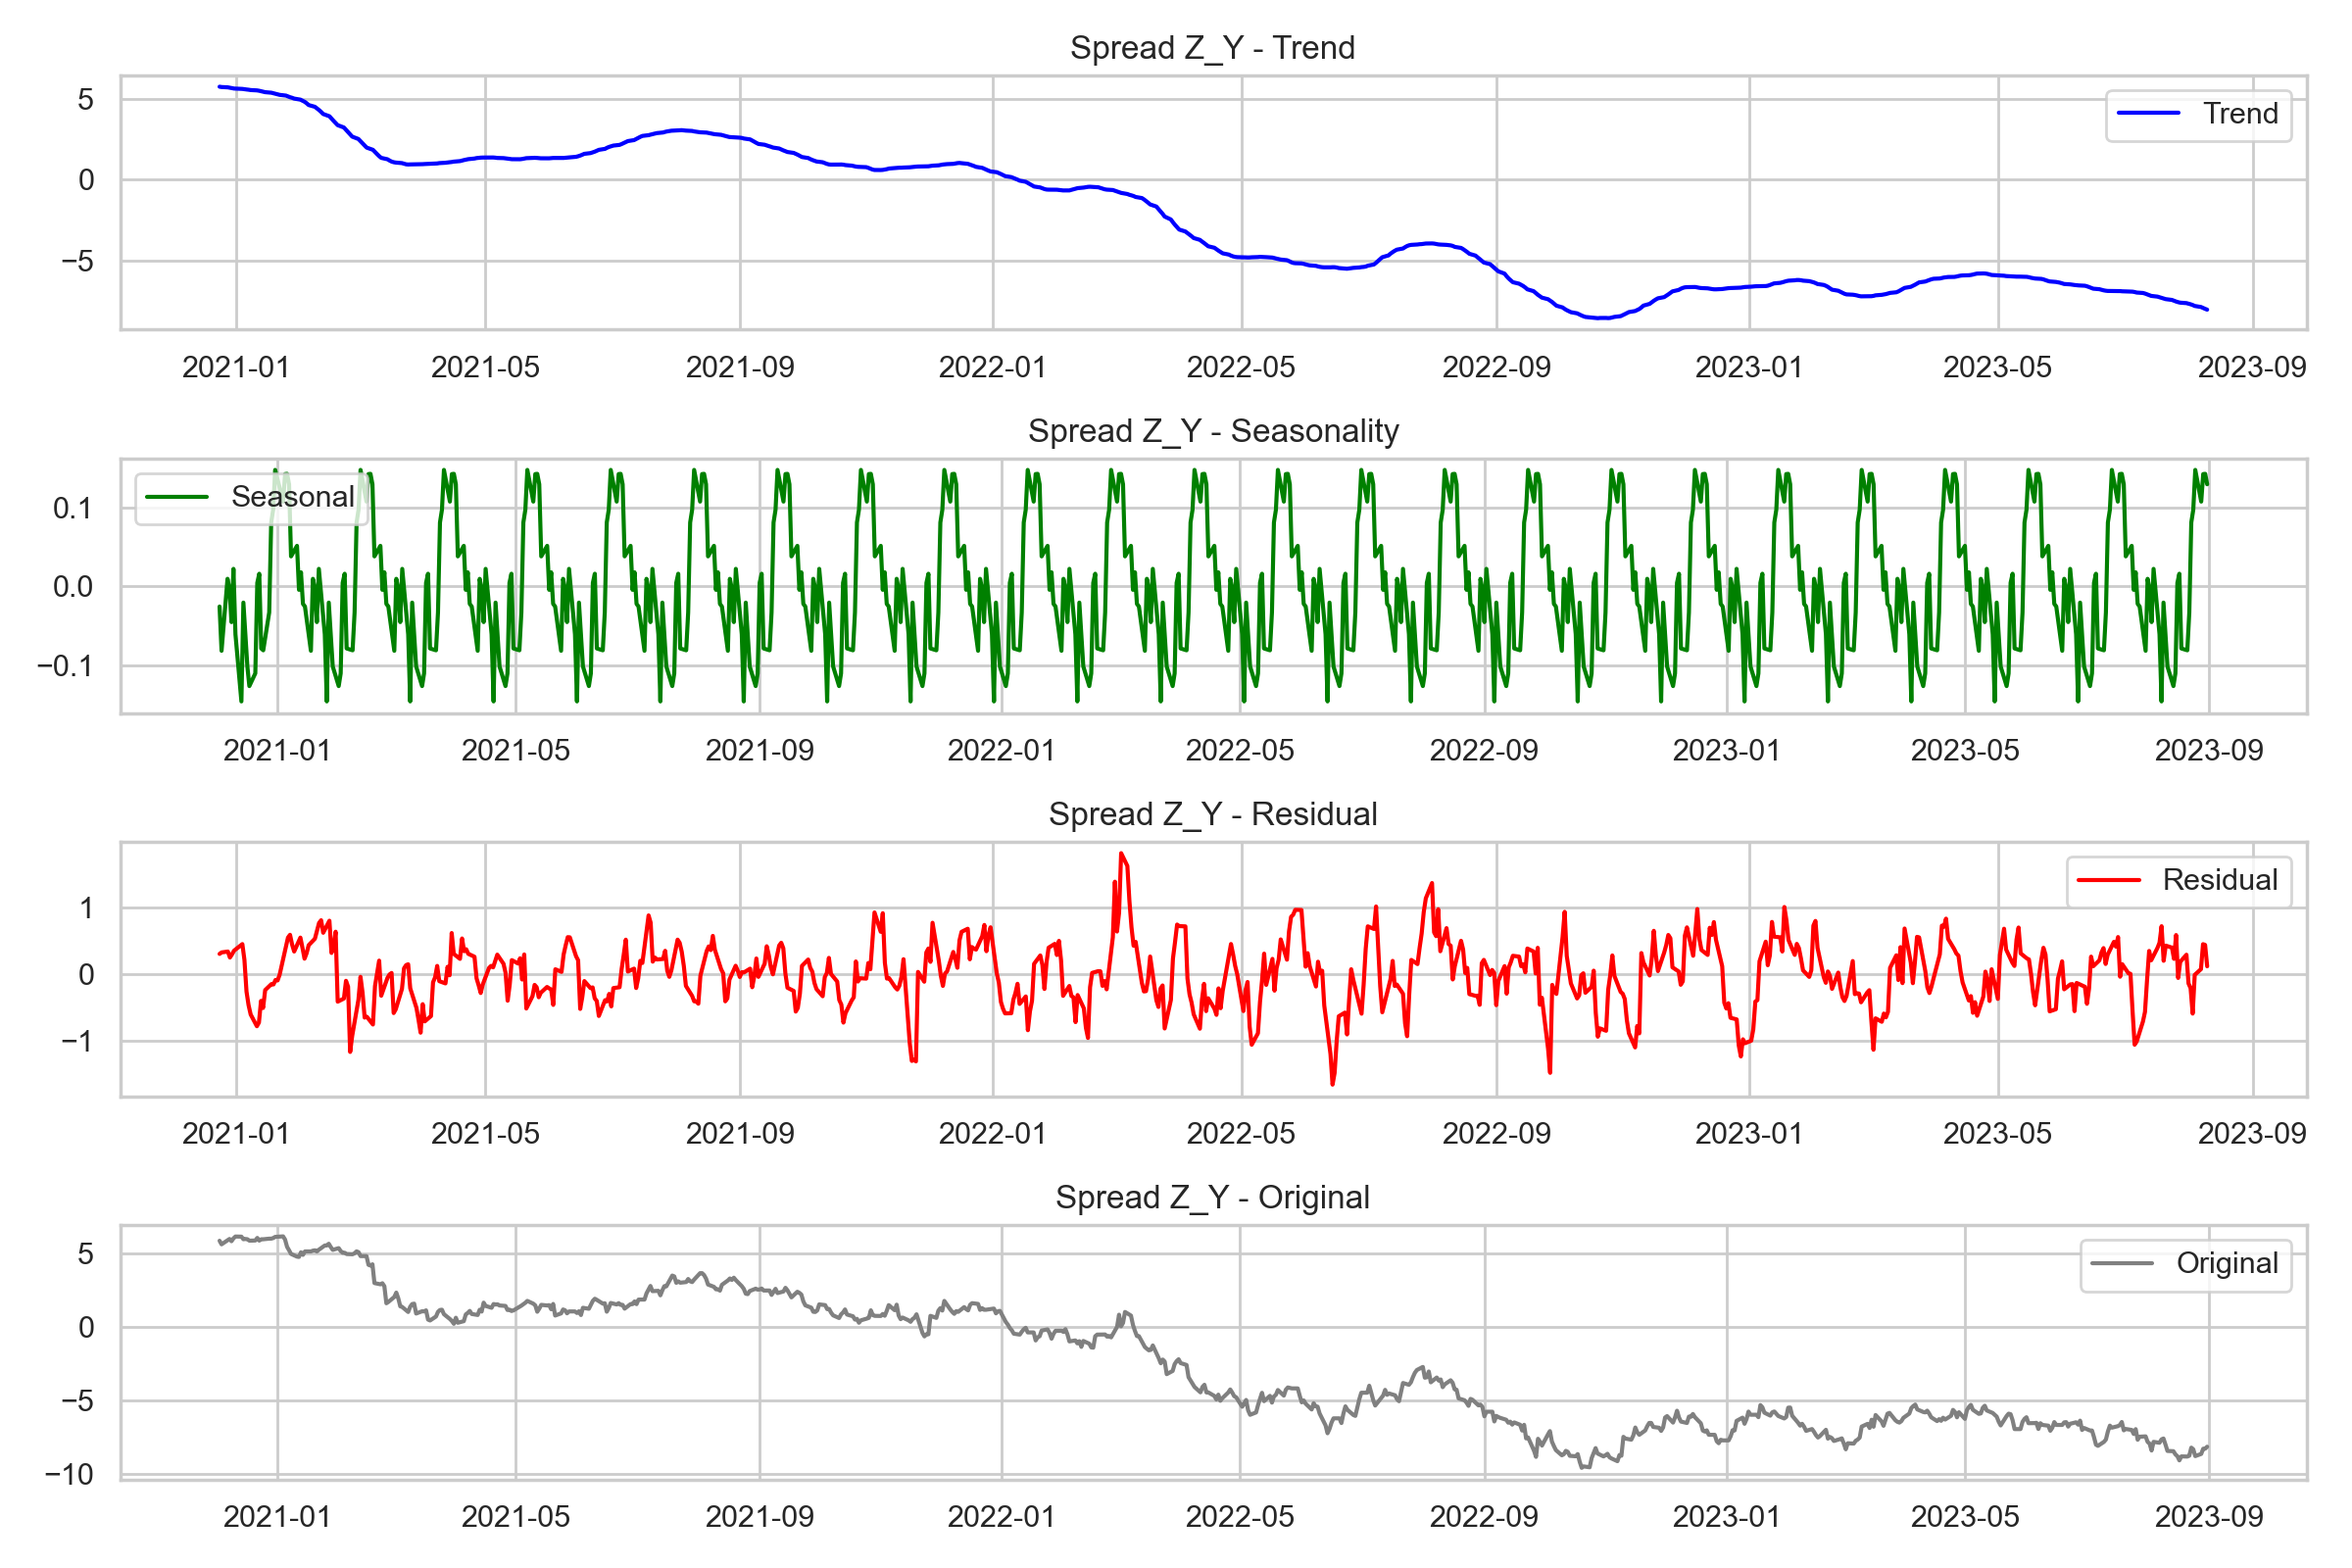

In [349]:
new_period = 30

decompose_Z_Y = seasonal_decompose(spread_Z_Y['spread'], model='additive', period=new_period)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decompose_Z_Y.trend, label='Trend', color='blue')
plt.title('Spread Z_Y - Trend')
plt.legend()

plt.subplot(412)
plt.plot(decompose_Z_Y.seasonal, label='Seasonal', color='green')
plt.title('Spread Z_Y - Seasonality')
plt.legend()

plt.subplot(413)
plt.plot(decompose_Z_Y.resid, label='Residual', color='red')
plt.title('Spread Z_Y - Residual')
plt.legend()

plt.subplot(414)
plt.plot(spread_Z_Y['spread'], label='Original', color='grey')
plt.title('Spread Z_Y - Original')
plt.legend()

plt.tight_layout()
plt.show()

For this second spread between Z and Y, contrary to the previous one, we can see that it shows a downward trend. This is consistent with what we observed in the previous sections. The seasonality pattern here is although not as clear as before because the residuals are oscillating a lot which makes it difficult to conclude on the existence of a clear pattern.

### 4. Cross Spread Analysis

Now that we have analyzed the dynamics of each spread individually, we will focus in this next part on the dynamics of the two spreads in relation to each other.

#### 4.1. Correlation of the Spreads

Let's first start by computing the correlation between the two spreads.

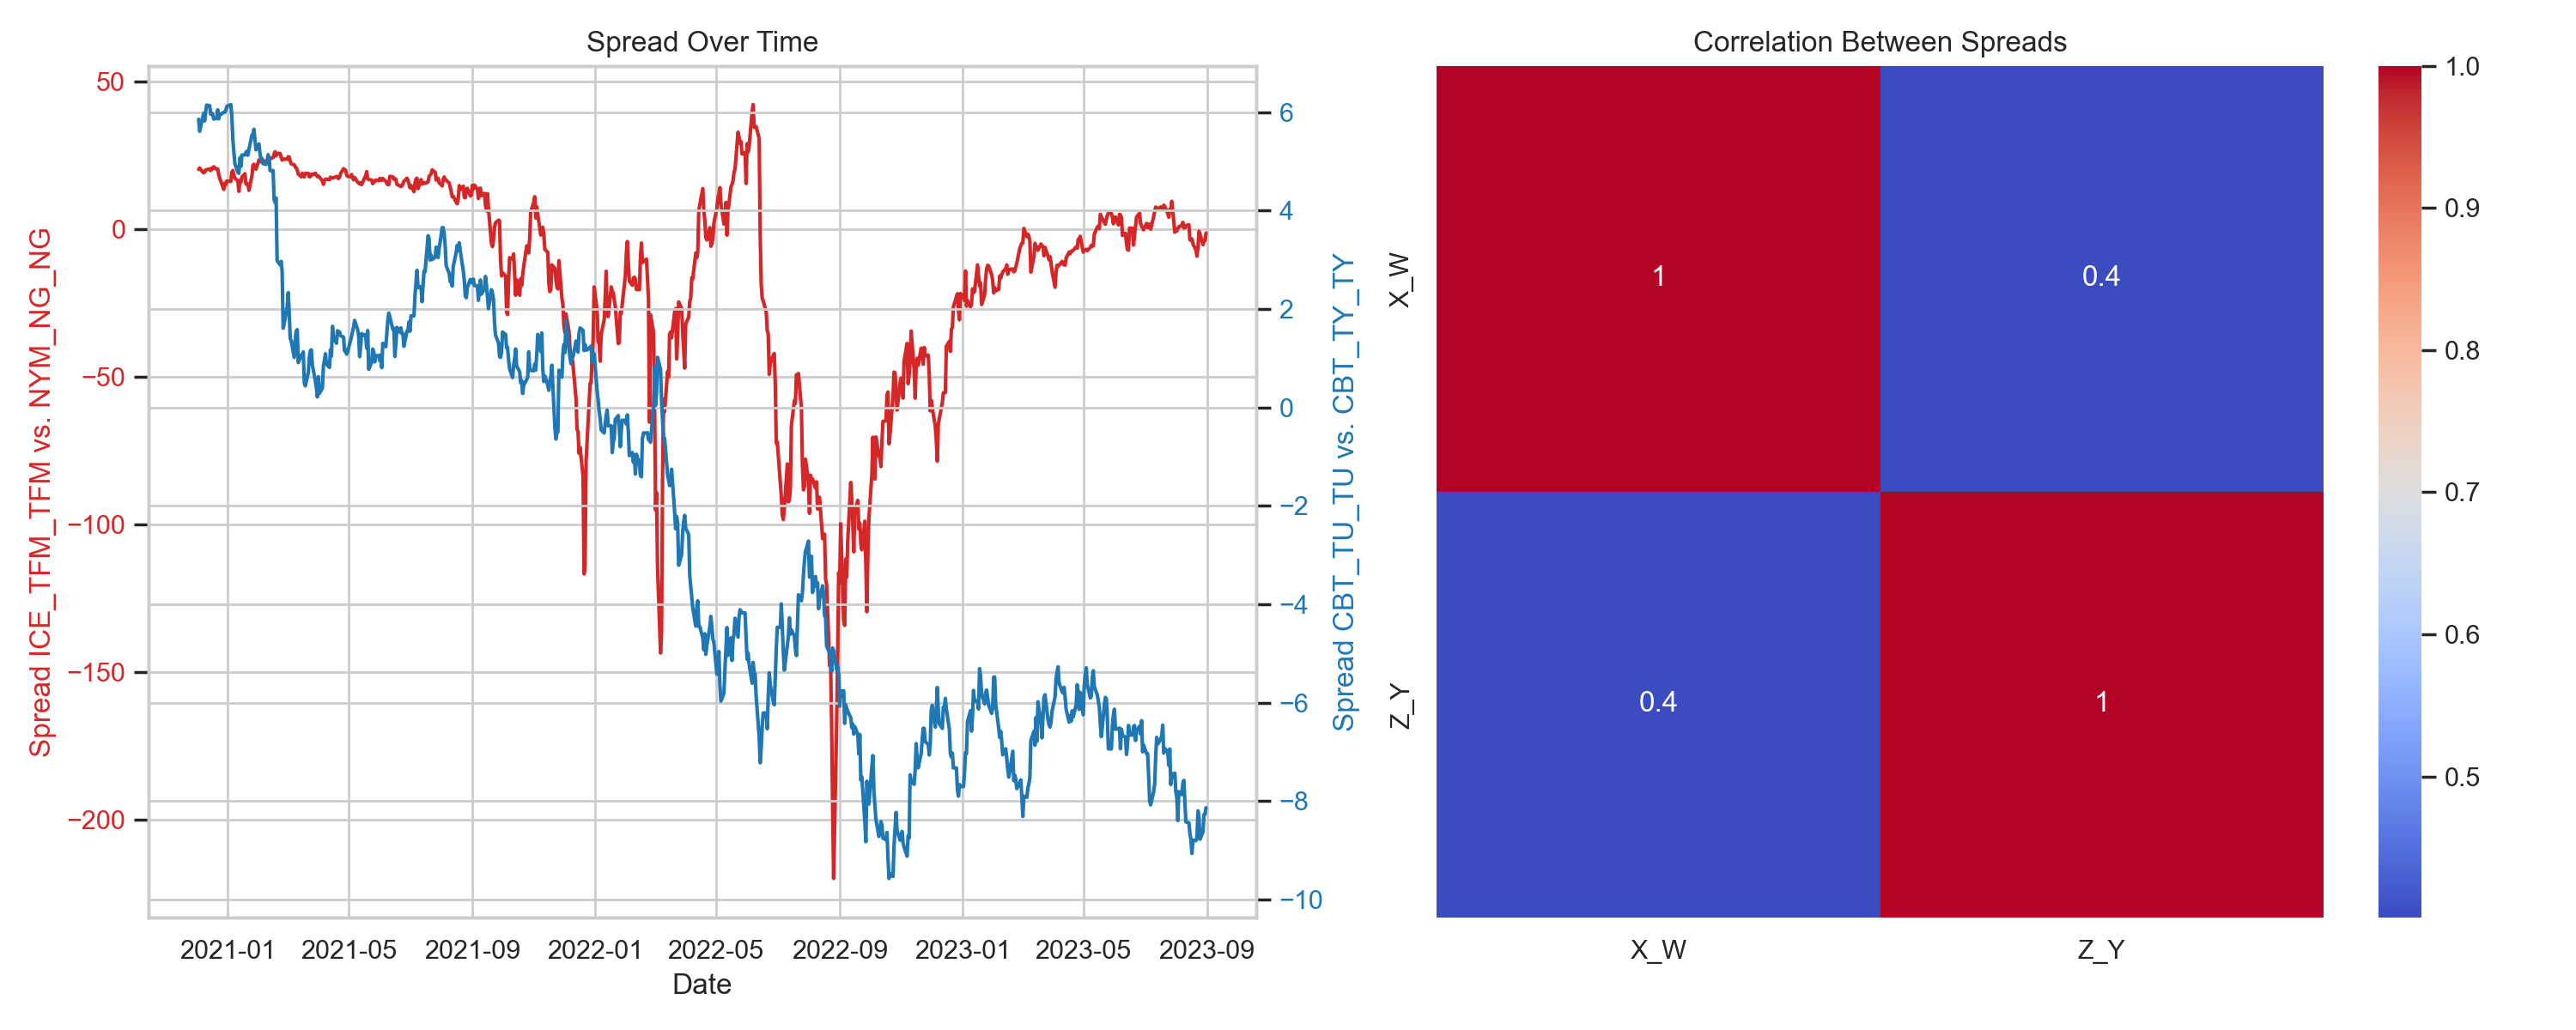

X_W       Z_Y
X_W  1.000000  0.400968
Z_Y  0.400968  1.000000

In [350]:
aligned_spreads = pd.concat([spread_X_W, spread_Z_Y], axis=1)
aligned_spreads.columns = ['X_W', 'Z_Y']

correlation = aligned_spreads.corr()

plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Spread ICE_TFM_TFM vs. NYM_NG_NG', color=color)
ax1.plot(spread_X_W.index, spread_X_W['spread'], label='ICE_TFM_TFM vs. NYM_NG_NG', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Spread CBT_TU_TU vs. CBT_TY_TY', color=color)
ax2.plot(spread_Z_Y.index, spread_Z_Y['spread'], label='CBT_TU_TU vs. CBT_TY_TY', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Spread Over Time')

plt.subplot(1, 2, 2)
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Between Spreads')

plt.tight_layout()
plt.show()

correlation

The first plot allows us to see how the two spreads are moving over time. We can see that the spread between X and W is much more volatile than the spread between Z and Y, while the latter lives between +5 and -10, the former is moving between +50 and -200, which is something we already showed in the previous part. We can also see that the spread between X and W is much more negative than the spread between Z and Y. It looks like the two spreads have some dynamics in common.

The correlation coefficient between Spread_X_W (ICE_TFM_TFM vs. NYM_NG_NG) and Spread_Z_Y (CBT_TU_TU vs. CBT_TY_TY) is approximately 0.40. This indicates a moderate positive correlation, suggesting that when one spread moves, the other also tends to move in the same direction, albeit not as strongly.

#### 4.2. Correlation of the differences (Spread - Rolling Average)

Coming back on our Rolling Average Analysis, we will now compute the correlation between the differences of our spreads with their rolling-average.

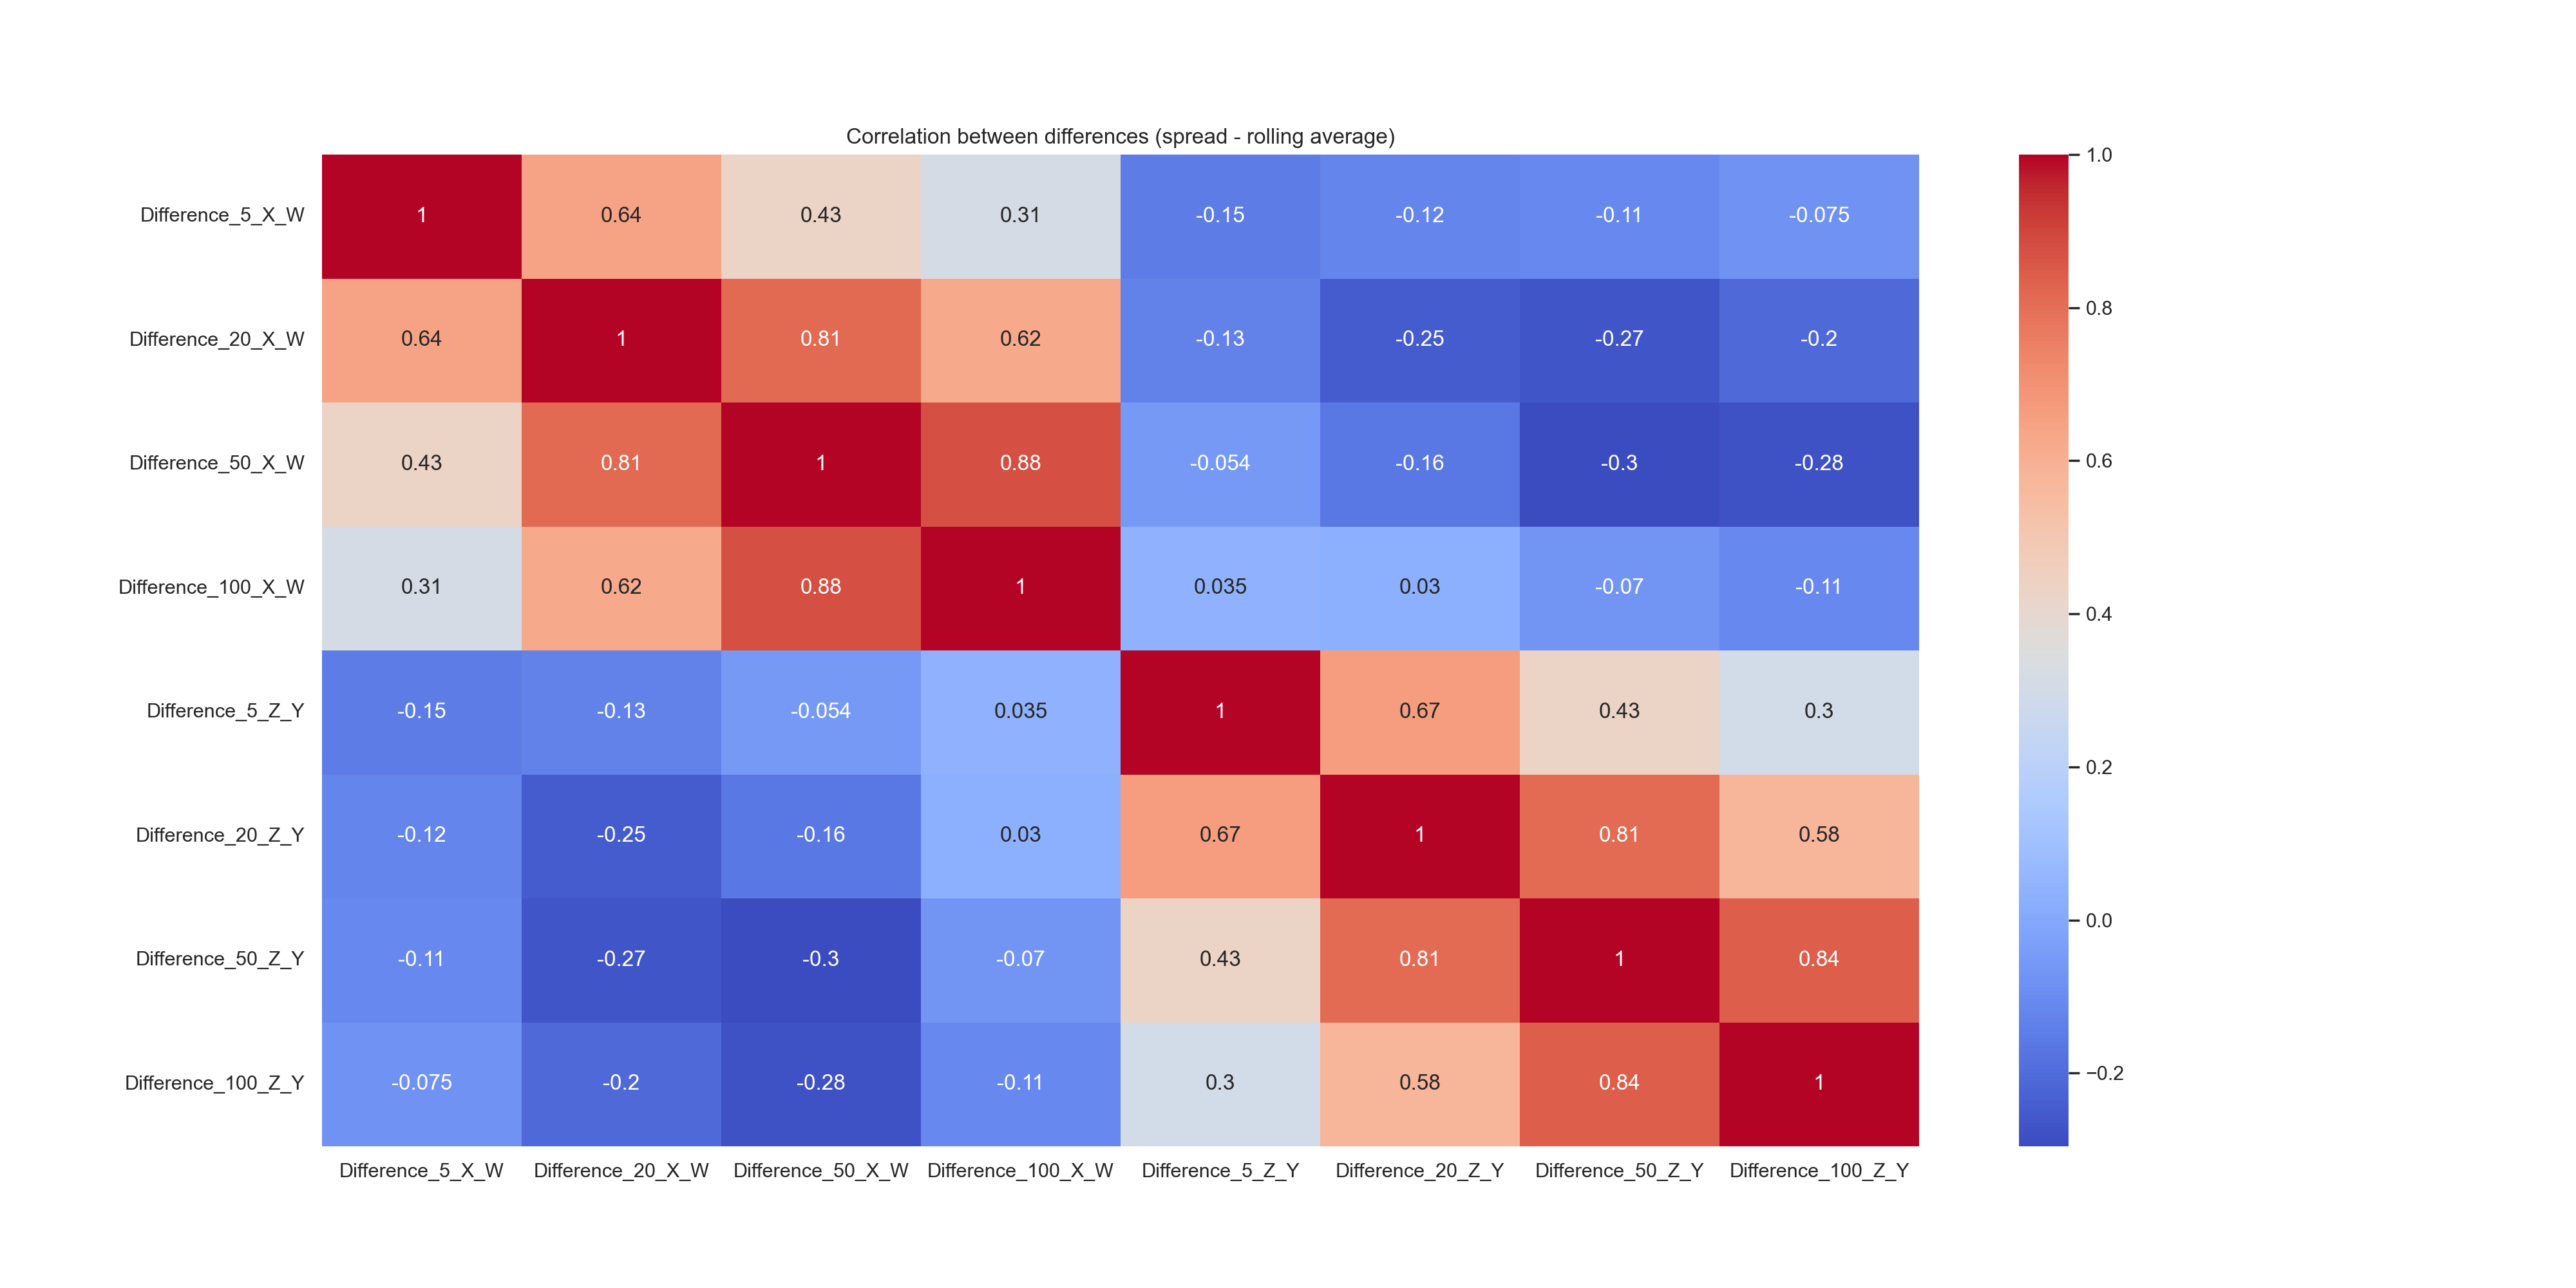

In [351]:
difference_data = pd.merge(difference_data_X_W, difference_data_Z_Y, suffixes=('_X_W', '_Z_Y'), left_index=True,
                           right_index=True)

plt.figure(figsize=(20, 10))
sns.heatmap(difference_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between differences (spread - rolling average)')
plt.show()

* Within the Same Spread (X_W and Z_Y):

For both spreads X_W and Z_Y, there's a strong positive correlation among deviations calculated with different window sizes. This is more pronounced for adjacent window sizes. For example, in spread X_W, the deviation for a 20-day rolling average is strongly correlated with both 50-day (0.81) and 5-day (0.64) deviations. Similarly, in spread Z_Y, the 50-day deviation is strongly correlated with both 20-day (0.81) and 100-day (0.84) deviations.

The correlation tends to decrease as the difference in window sizes increases. For instance, in spread X_W, the correlation between 5-day and 100-day deviations is 0.31, which is lower compared to the correlation between 5-day and 20-day deviations.

* Between the Two Spreads (X_W vs Z_Y):

The correlation between the deviations of spread X_W and spread Z_Y is generally negative or low, suggesting that the deviations in one spread do not reliably predict the deviations in the other one. For instance, the 5-day deviation of X_W has a correlation of -0.15 with the 5-day deviation of Z_Y. The largest correlation is observed between the 50-day deviations of the two spreads, which is -0.3 (minus meaning that the two spreads tend to move in opposite directions).

The differences within the same spread (either X_W or Z_Y) are more correlated with each other, especially for closer window sizes. This suggests that the spreads behave similarly over different time scales. There is generally a low negative correlation between the differences of the two different spreads (X_W and Z_Y), indicating that the movements in one spread do not strongly correspond with movements in the other one. This suggests that the two spreads may be influenced by different factors or have different underlying dynamics.

#### 4.3. Cross-Correlation of the Spreads

This correlation analysis before showed that the two spread were positively correlated (around 0.4). The cross-correlation plot will now show how the correlation between the daily returns of the two spreads changes over different lag periods (from -30 to +30 days). The purpose is to uncover potential lead-lag relationships.

A significant peak or trough in this plot would indicate that changes in one spread are consistently leading or lagging changes in the other one.

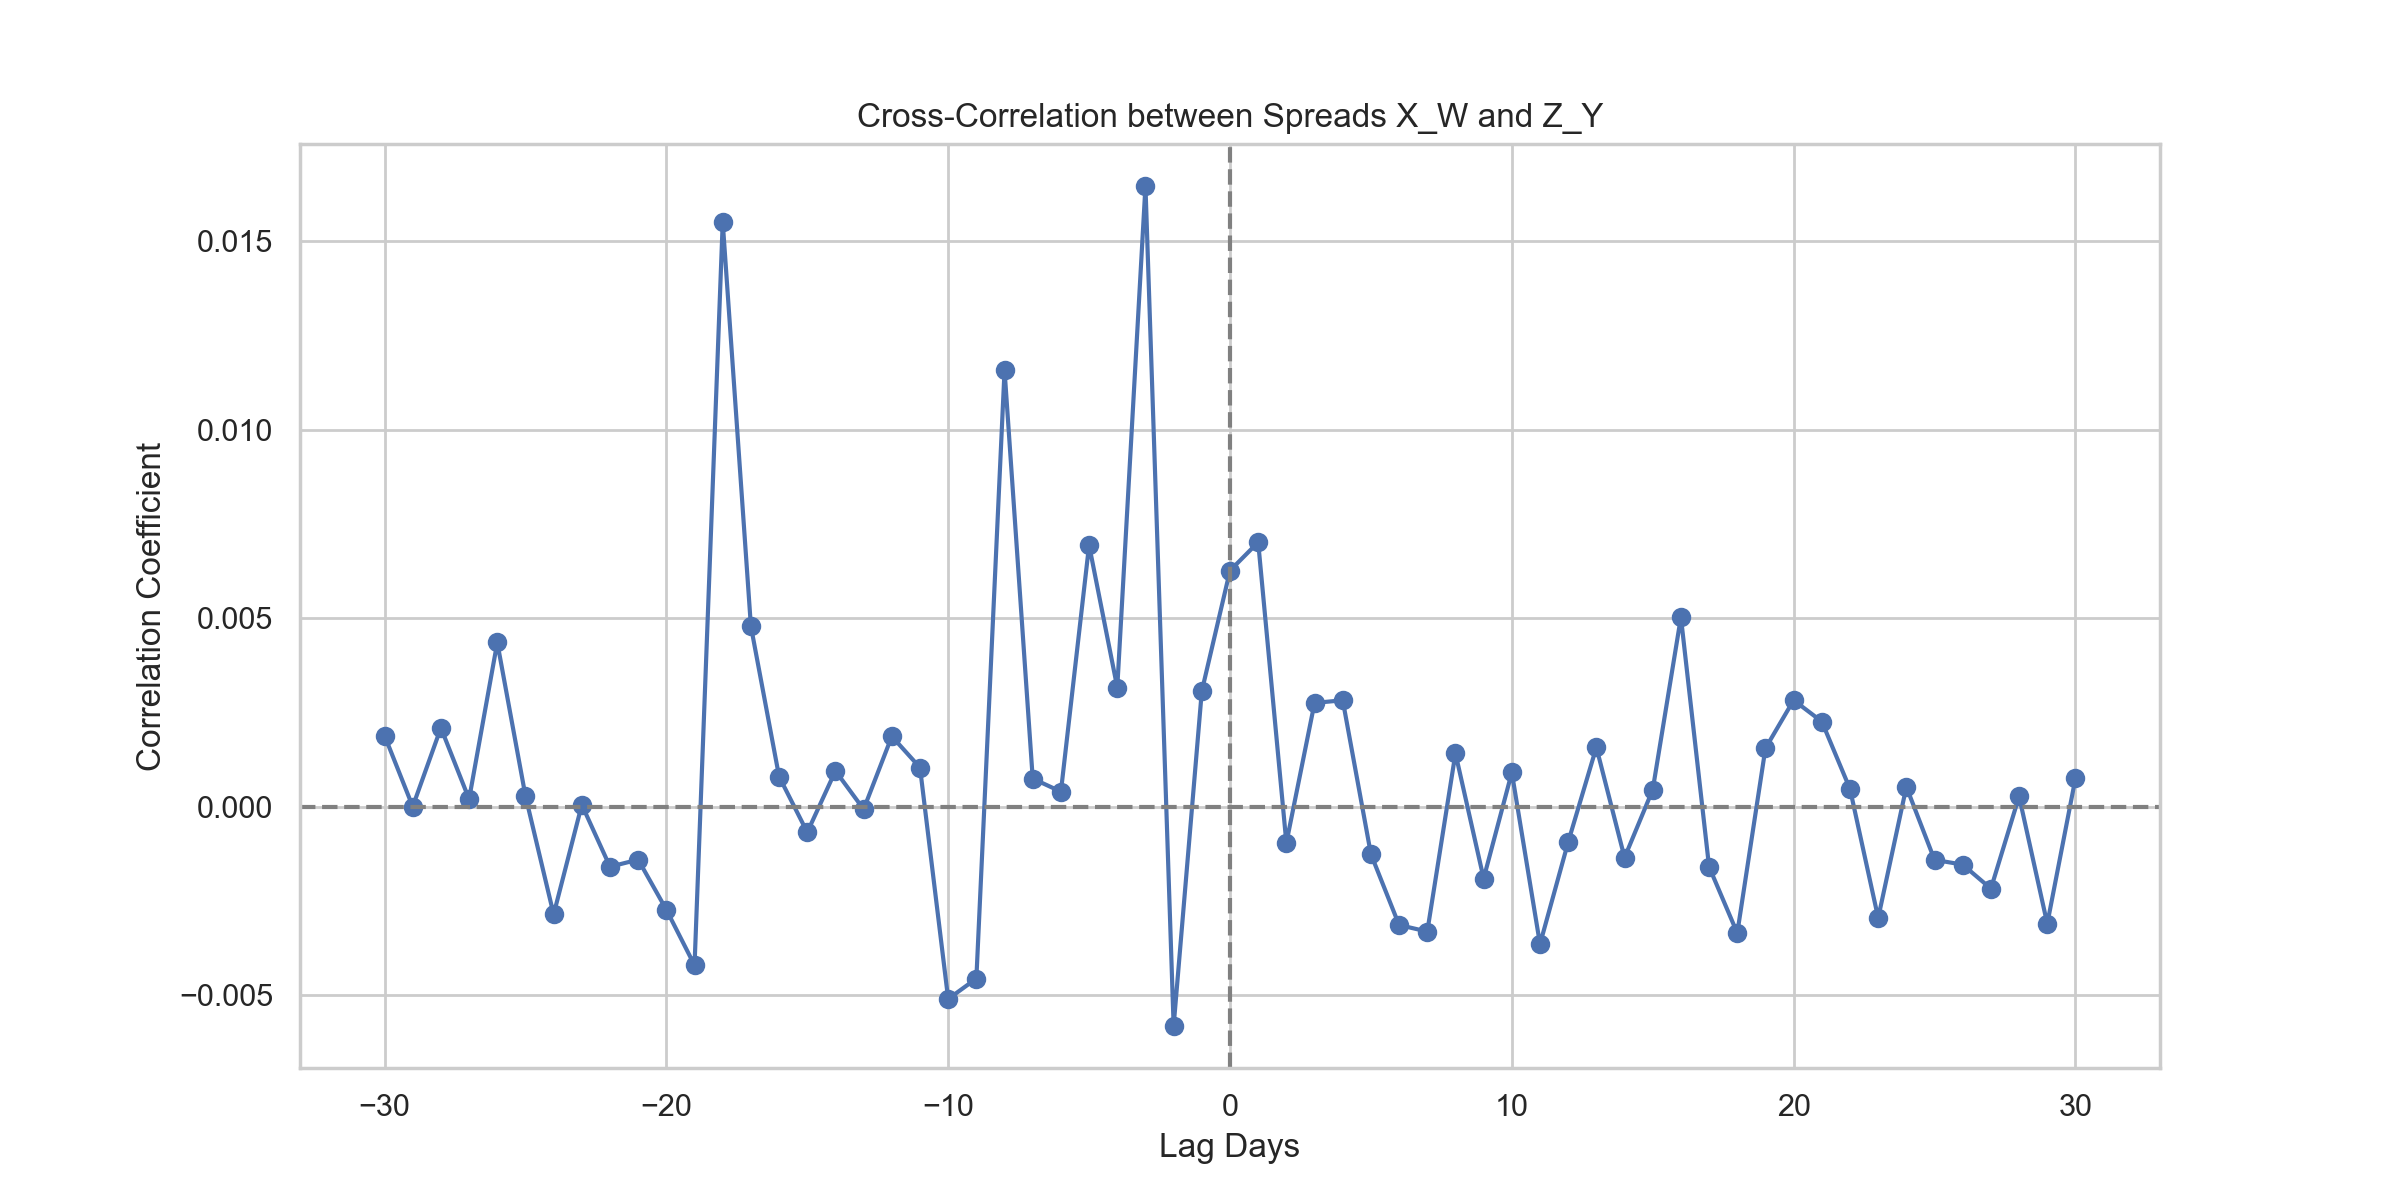

In [352]:
lags = range(-30, 31)
cross_correlation = [daily_returns_X_W.corr(daily_returns_Z_Y.shift(lag)) for lag in lags]

plt.figure(figsize=(12, 6))
plt.plot(lags, cross_correlation, marker='o')
plt.title('Cross-Correlation between Spreads X_W and Z_Y')
plt.xlabel('Lag Days')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axvline(x=0, linestyle='--', color='gray')
plt.show()

The cross-correlation values fluctuate around zero for most lags, indicating a weak relationship between the daily returns of the two spreads across different time lags. A positive value indicates that as one series moves up, the other series also tends to move up. Conversely, a negative value indicates an inverse relationship, where one series tends to move in the opposite direction of the other after the lag period.

The maximum cross-correlation observed is approximately 0.016, which occurs at a lag of -3 days. This suggests a very weak positive correlation when the daily returns of spread Z_Y are shifted 3 days ahead of spread X_W. The peak itself, though being the highest in the observed range, is very close to zero. This implies that even at its most correlated point, the relationship between the changes in the two spreads is weak and might not be statistically significant.

There is no strong evidence from this analysis that changes in one spread consistently lead or lag changes in the other one. In other words, the movements in spread X_W do not show a clear pattern of leading or following the movements in spread Z_Y, and vice versa.

### 5. Conclusion

Our analysis was about the spread of two different pairs of futures. The goal was to identify the dynamics of each spread individually and then to identify the dynamics of the two spreads in relation to each other. To do so, we explored different aspects of our data, from basic statistics to risk metrics, correlation and seasonality. Those analyses allowed us to identify some patterns in our data and to better understand the dynamics of the spreads.

The first spread we analyzed was the spread between the Dutch TTF Natural Gas Futures (ICE TFM) and Henry Hub Natural Gas Futures (NYM NG). We identified that the spread experienced several large drops in 2022 before recovering in 2023. It now seems to be quite stable. We also identified that the spread is mean-reverting and that futures prices on Natural Gas are not trending in the long run, but rather oscillate, sometimes quite strongly, around a historical mean value. Those oscillations can be understood through the seasonality of Natural Gas throughout the year and by considering geopolitical events that can affect the price in different countries. The statistics on the difference between the spread and its rolling averages also showed that the spread tends to be below its rolling average, with more pronounced fluctuations and extreme negative values as the period of the rolling average increases. Then looking at some risk metrics, we identified some period of stress that we were able to relate to economic and geopolitical events. Finally, the autocorrelation analysis suggested that the daily returns of the spread could exhibit strong or consistent dependencies on its past values for some specific lags and that this could be useful in financial modeling and forecasting.

The second spread we analyzed was the spread between the 10-Year U.S. Treasury Note (CBT TY) and the 2-Year U.S. Treasury Note (CBT TU). We identified that the spread experienced a downward trend since 2021 until 2023 and that it now seems to have stabilized in 2023. We also identified that the spread is generally close to its rolling average, with relatively small fluctuations over longer periods. We could not identify any strong seasonality pattern in this spread but instead, looking at some risk metrics, we identified some outliers that we were able to relate to economic events such as the Fed rate hikes. In this case, the autocorrelation analysis suggested that the daily returns of the spread do not exhibit any relevant dependencies on its past values for the given range of lags.

Finally, we focused on the dynamics of the two spreads in relation to each other. The correlation analysis showed that the two spreads were positively correlated (around 0.4) but a further analysis on their cross-correlation did not show any strong evidence that changes in one spread consistently lead or lag changes in the other one. This suggests that the two spreads may be influenced by different factors or have different underlying dynamics. Looking at the correlation of the deviations of the spreads with their rolling averages, we identified that the differences within the same spread were more correlated with each other, especially for closer window sizes. This suggests that the spreads behave similarly over different time scales. And that there was generally a low negative correlation between the differences of the two different spreads, indicating that the movements in one spread do not strongly correspond with movements in the other one, even on different time scales.